In [1]:
from shearletNN.shearlets import getcomplexshearlets2D
from shearletNN.shearlet_utils import (
    frequency_shearlet_transform,
    spatial_shearlet_transform,
    ShearletTransformLoader,
    shifted_frequency_shearlet_transform,
    shifted_spatial_shearlet_transform,
)
from shearletNN.complex_resnet import (
    complex_resnet18,
    complex_resnet34,
    complex_resnet50,
)
from shearletNN.complex_deit import (
    complex_freakformer_small_patch2_LS,
    complex_directional_freakformer_tiny_patch4_LS,
    complex_freakformer_tiny_patch2_LS,
    complex_freakformer_tiny_patch1_LS,
    complex_freakformer_small_patch1_LS,
    complex_Lfreakformer_small_patch1_LS,
    complex_Lfreakformer_small_patch2_LS,
    complex_Lfreakformer_tiny_patch2_LS,
    complex_Lfreakformer_tiny_patch1_LS
)
from shearletNN.layers import CGELU, CReLU

import torch
import torchvision
from torchvision.transforms import v2
from torchvision import transforms

import gc
from tqdm import tqdm
import matplotlib.pyplot as plt


patch_size = 32
image_size = 32

rows, cols = image_size, image_size


shearlets, shearletIdxs, RMS, dualFrameWeights = getcomplexshearlets2D(
    rows,
    cols,
    1,  # scales per octave
    3,  # shear level (something like O(log of directions))
    1,  # octaves
    0.5,  # alpha
    wavelet_eff_support=image_size,
    gaussian_eff_support=image_size,
)

shearlets = torch.tensor(shearlets).permute(2, 0, 1).type(torch.complex64).to(0)

/home/jroth/miniforge3/envs/shearlets/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jroth/miniforge3/envs/shearlets/lib/python3.9/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def train(model, optimizer, loader, accumulate=1):
    model.train()
    loss = torch.nn.CrossEntropyLoss()

    for i, (X, y) in tqdm(enumerate(loader)):
        out = model(X.to(0))
        optimizer.zero_grad()
        l = loss(out, y.to(0)) / accumulate
        l.backward()
        if i % accumulate == (accumulate - 1):
            optimizer.step()


def accuracy(output, target, topk=(1,)):
    output = output.to(torch.device("cpu"))
    target = target.to(torch.device("cpu"))
    maxk = max(topk)
    batch_size = target.shape[0]

    _, idx = output.sort(dim=1, descending=True)
    pred = idx.narrow(1, 0, maxk).t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(dim=0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def epoch_accuracy(loader_s, student):
    student.eval()

    out_epoch_s = [
        accuracy(student(L.to(0)), y)[0].detach().cpu().item() for L, y in loader_s
    ]

    student.train()

    return sum(out_epoch_s) / len(out_epoch_s)


def test(network, test_loader):
    network.eval().to(0)
    test_loss = 0
    correct = 0
    total = 0
    test_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(0))
            test_loss += torch.nn.CrossEntropyLoss()(output, target.to(0)).item()
            pred = output.data.max(1, keepdim=True)[1].cpu()
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += target.shape[0]
        test_loss /= total
        test_losses.append(test_loss)
        print(
            "\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                test_loss, correct, total, 100.0 * correct / total
            )
        )


class IndexSubsetDataset:
    def __init__(self, ds, inds):
        self.ds = ds
        self.inds = inds

    def __iter__(self):
        for i in range(len(self.inds)):
            yield self[i]

    def __getitem__(self, i):
        return self.ds[self.inds[i]]

    def __len__(self):
        return len(self.inds)


def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear):
            linear_children.append((name, module))
    return linear_children

In [3]:
def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear) or isinstance(mod, torch.nn.Conv2d):
            linear_children.append((name, module))
    return linear_children


def getattrrecur(mod, s):
    s = s.split(".")
    for substr in s:
        mod = getattr(mod, substr)
    return mod


def setattrrecur(mod, s, value):
    s = s.split(".")
    for substr in s[:-1]:
        mod = getattr(mod, substr)
    setattr(mod, s[-1], value)


def spectral_normalize(model):
    for name, mod in linearleaves(model):
        setattrrecur(
            model,
            name,
            torch.nn.utils.parametrizations.spectral_norm(getattrrecur(mod, name)),
        )

    return model

In [4]:
def batch_cov_3d(points, mean, mask):
    """
    for our purposes we want to batch the covariance along the channel dimension (originally 1) and compute it over the batch dimension (originally 0)

    we need a covariance matrix for each channel along the batch dimension, so of shape (C, 2, 2)

    Input: points \in (B, C, H, W, D)

    """
    points = points - mean
    mask = (((points * mask)[:, 0, ..., 0] != 0) * ((points * mask)[:, 0, ..., 1] != 0)).flatten()
    points = points.permute(1, 0, 2, 3, 4)  # Channels first for the reshape
    C, B, H, W, D = points.size()
    N = B * H * W
    assert mask.shape[0] == B * H * W
    diffs = points.reshape(C * N, D)
    prods = torch.bmm(diffs.unsqueeze(2), diffs.unsqueeze(1)).reshape(C, N, D, D)
    prods[:, ~mask] = 0
    # print(mask.type(torch.int32).sum() / N)
    # print(mask.type(torch.int32).max(), mask.type(torch.int32).min())
    bcov = prods.sum(dim=1) / mask.type(torch.int32).sum() # this is almost right.  
    # We need to make sure we are correctly doing this for case when one or the other is zero.  Probably means masking before bmm.
    return bcov  # (C, D, D)


def loader_mean_cov(loader, mask=None):
    total = 0
    mean = None
    cov = None

    for x, y in loader:
        total += 1
        if mean is None:
            mean = torch.stack((
                torch.sum(x.real * mask[..., 0], dim=(0, 2, 3), keepdim=True) / ((x.real * mask[..., 0])[:, 0] != 0).type(torch.int32).sum(),
                torch.sum(x.imag * mask[..., 1], dim=(0, 2, 3), keepdim=True) / ((x.imag * mask[..., 1])[:, 1] != 0).type(torch.int32).sum(),
                ),
                -1
            )
        else:
            mean += torch.stack((
                torch.sum(x.real * mask[..., 0], dim=(0, 2, 3), keepdim=True) / ((x.real * mask[..., 0])[:, 0] != 0).type(torch.int32).sum(),
                torch.sum(x.imag * mask[..., 1], dim=(0, 2, 3), keepdim=True) / ((x.imag * mask[..., 1])[:, 1] != 0).type(torch.int32).sum(),
                ),
                -1
            )

        if cov is None:
            cov = batch_cov_3d(torch.stack((x.real, x.imag), dim=-1), mean, mask)

        else:
            cov = ( ( (total - 2) / (total - 1) ) * cov ) + ( (1 / total) * batch_cov_3d(torch.stack((x.real, x.imag), dim=-1), mean / total, mask) )

    return mean, cov


class Normalizer:
    def __init__(self, mean, cov, eps=1e-6):
        self.mean = mean
        self.cov = cov
        self.epsilon_matrix = torch.eye(2) * eps

        # Inv and sqrtm is done over 2 inner most dimension [..., M, M] so it should be [..., 2, 2] for us.
        # torch has no matrix square root, so we have
        L, Q = torch.linalg.eigh(
            torch.linalg.inv((self.cov + self.epsilon_matrix.unsqueeze(0).to(self.cov.device)).to(torch.float64))
        )  # low precision dtypes not supported
        # eigenvalues of positive semi-definite matrices are always real (and non-negative)
        diag = torch.diag_embed(L ** (0.5))
        self.inv_sqrt_var = Q @ diag @ Q.mH  # var^(-1/2), (C, 2, 2)

    def __call__(self, inputs):
        # Separate real and imag so I go from shape [...] to [..., 2]
        inputs = torch.stack((inputs.real, inputs.imag), -1)

        zero_mean = inputs - self.mean
        # (C, 2, 2) @ (B, H, W, C, 2, 1) -> (B, H, W, C, 2, 1)
        inputs_hat = torch.matmul(
            self.inv_sqrt_var.to(inputs.dtype), zero_mean.permute(0, 2, 3, 1, 4).unsqueeze(-1)
        )
        # Then I squeeze to remove the last shape so I go from [..., 2, 1] to [..., 2].
        # Use reshape and not squeeze in case I have 1 channel for example.
        squeeze_inputs_hat = torch.reshape(inputs_hat, shape=inputs_hat.shape[:-1]).permute(0, 3, 1, 2, 4)
        # Get complex data
        complex_inputs_hat = torch.complex(
            squeeze_inputs_hat[..., 0], squeeze_inputs_hat[..., 1]
        ).type(torch.complex64)

        return complex_inputs_hat


def tensor_batch_cov_3d(points, mean):
    """
    for our purposes we want to batch the covariance along the channel dimension (originally 1) and compute it over the batch dimension (originally 0)

    we need a covariance matrix for each channel along the batch dimension, so of shape (C, 2, 2)

    Input: points \in (B, C, H, W, D)

    """
    points = points - mean
    points = points.permute(0, 1, 2, 3, 4)  # Channels first for the reshape
    B, C, H, W, D = points.size()
    N = H * W
    diffs = points.reshape(B, C * N * D) # previously C, N * D
    # potentially a sizeable matrix (256 * 256 * 30 * 2) square
    prods = torch.bmm(diffs.unsqueeze(2), diffs.unsqueeze(1)).reshape(B, C * N * D, C * N * D)
    bcov = prods.sum(dim=0) / N
    return bcov  # (D, D)


def pixel_loader_mean_var(loader):
    total = 0
    mean = None
    var = None

    for x, y in loader:
        total += 1
        if mean is None:
            mean = torch.stack((
                torch.mean(x.real, dim=(0, 1), keepdim=True),
                torch.mean(x.imag, dim=(0, 1), keepdim=True),
                ),
                -1
            )
        else:
            mean += torch.stack((
                torch.mean(x.real, dim=(0, 1), keepdim=True),
                torch.mean(x.imag, dim=(0, 1), keepdim=True),
                ),
                -1
            )

        if var is None:
            var = torch.stack((
                torch.var(x.real.type(torch.float64), dim=(0, 1), keepdim=True),
                torch.var(x.imag.type(torch.float64), dim=(0, 1), keepdim=True),
                ),
                -1
            )
        else:
            est_var = torch.stack((
                torch.var(x.real.type(torch.float64), dim=(0, 1), keepdim=True),
                torch.var(x.imag.type(torch.float64), dim=(0, 1), keepdim=True),
                ),
                -1
            )

            var = ( ( (total - 2) / (total - 1) ) * var ) + ( (1 / total) * est_var )
        

    return mean, var


class PixelNormalizer:
    def __init__(self, mean, cov, eps=1e-6):
        self.mean = mean
        self.cov = cov
        self.epsilon_matrix = torch.eye(2) * eps

        # Inv and sqrtm is done over 2 inner most dimension [..., M, M] so it should be [..., 2, 2] for us.
        # torch has no matrix square root, so we have
        L, Q = torch.linalg.eigh(
            torch.linalg.inv((self.cov + self.epsilon_matrix.unsqueeze(0).to(self.cov.device)).to(torch.float64))
        )  # low precision dtypes not supported
        # eigenvalues of positive semi-definite matrices are always real (and non-negative)
        diag = torch.diag_embed(L ** (0.5))
        self.inv_sqrt_var = Q @ diag @ Q.mH  # var^(-1/2), (C, 2, 2)

    def __call__(self, inputs):
        B, C, H, W = inputs.size()
        N = H * W
        # Separate real and imag so I go from shape [...] to [..., 2]
        inputs = torch.stack((inputs.real, inputs.imag), -1)

        zero_mean = inputs - self.mean
        # (C * N * 2, C * N * 2) @ (B, C * N * 2, 1) -> (B, C * N * 2, 1)
        inputs_hat = torch.matmul(
            self.inv_sqrt_var.to(inputs.dtype), zero_mean.reshape(B, C * N * 2).unsqueeze(-1)
        ).reshape(B, C, H, W, 2, 1)
        # Then I squeeze to remove the last shape so I go from [..., 2, 1] to [..., 2].
        # Use reshape and not squeeze in case I have 1 channel for example.
        squeeze_inputs_hat = torch.reshape(inputs_hat, shape=inputs_hat.shape[:-1])
        # Get complex data
        complex_inputs_hat = torch.complex(
            squeeze_inputs_hat[..., 0], squeeze_inputs_hat[..., 1]
        ).type(torch.complex64)

        return complex_inputs_hat
    
def symlog(x, threshold=1):
    return torch.sign(x) * torch.log(1 + torch.abs(x / threshold))

def symsqrt(x):
    return torch.sign(x) * torch.pow(torch.abs(x), 0.75)

def complex_symsqrt(x):
    real = x.real
    imag = x.imag

    return torch.complex(symsqrt(real), symsqrt(imag))

def complex_symlog(x, threshold=1):
    real = x.real
    imag = x.imag

    return torch.complex(symlog(real, threshold), symlog(imag, threshold))

In [5]:
batch_size_train = 1024

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


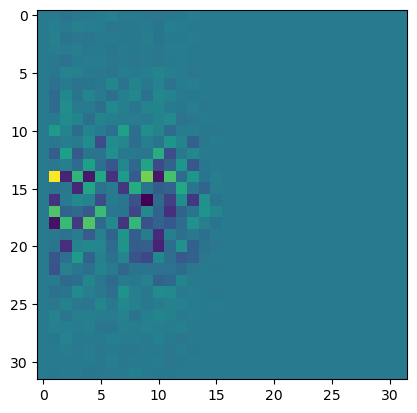

49it [00:06,  7.11it/s]
49it [00:06,  7.09it/s]
49it [00:06,  7.04it/s]


tensor(0.0509, device='cuda:0') tensor(0.5847, device='cuda:0')
Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]

torch.Size([1, 1, 32, 32, 2])
torch.Size([31457280, 2])
tensor([ 0.0115,  0.0116,  0.0116, -0.0255, -0.0253, -0.0252, -0.0255, -0.0259,
        -0.0110, -0.0112,  0.0214,  0.0216,  0.0218,  0.0014,  0.0010,  0.0007,
         0.0007,  0.0010, -0.0211, -0.0212,  0.0176,  0.0178,  0.0179,  0.0028,
         0.0023,  0.0021,  0.0020,  0.0023, -0.0171, -0.0174], device='cuda:0')
tensor([ 0.0055,  0.0053,  0.0050, -0.0946, -0.0970, -0.0977, -0.0969, -0.0944,
        -0.0049, -0.0054,  0.0084,  0.0082,  0.0078, -0.1429, -0.1468, -0.1481,
        -0.1467, -0.1427, -0.0078, -0.0083,  0.0098,  0.0096,  0.0094, -0.1848,
        -0.1899, -0.1915, -0.1898, -0.1847, -0.0092, -0.0097], device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0708, device='cuda:0')
tensor([0.2064, 0.2063, 0.2063, 0.2026, 0.2026, 0.2025, 0.2026, 0.2026, 0.2064,
        0.2064, 0.2012, 0.2012, 0.2012, 0.1983, 0.1983, 0.1983, 0.1983, 0.1983,
        0.2012, 0.2012, 0.2027, 0.2026, 0.2026, 0.2008, 0.2008, 0.2008, 0.2008

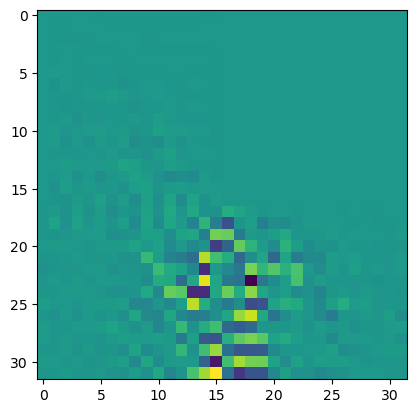

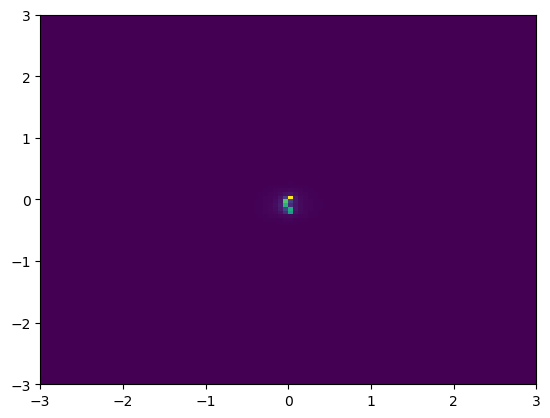

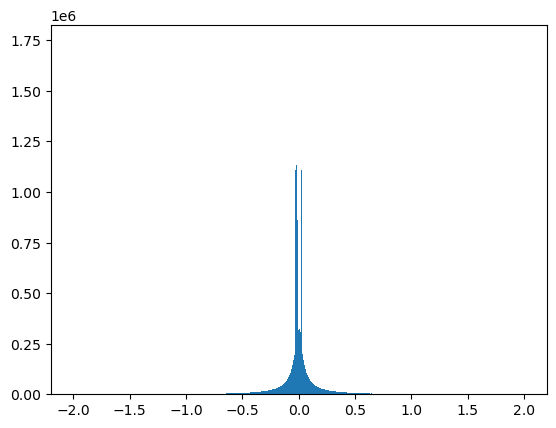

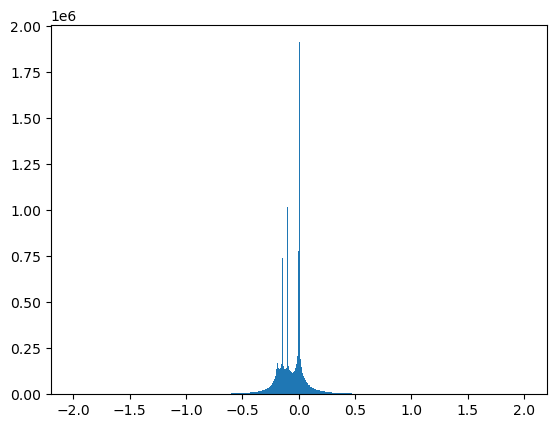

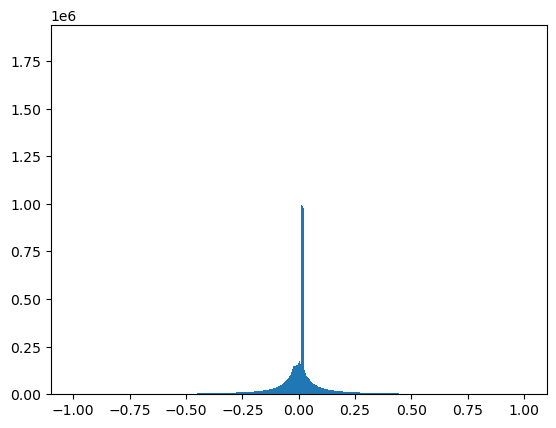

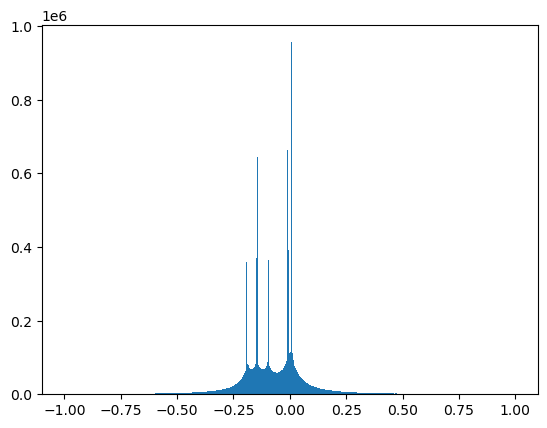

0it [00:03, ?it/s]


In [6]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


coeff_fn = frequency_shearlet_transform

def threesquare(img):
    return torch.cat((
        img[..., :img.shape[-2] // 2, :img.shape[-1] // 2],
        img[..., img.shape[-2] // 2:, :img.shape[-1] // 2],
        img[..., :img.shape[-2] // 2, img.shape[-1] // 2:],
        # img[..., img.shape[-2] // 2:, img.shape[-1] // 2:],
                      ), 1)


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

def shearlet_transform(img):
    return coeff_fn(img.to(0), shearlets.to(0), patch_size)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

for x, y in train_loader:
    plt.imshow(x[0, 0].real.cpu().numpy())
    plt.show()
    break

pixel_mean, pixel_var = pixel_loader_mean_var(tqdm(train_loader))

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

def shearlet_transform(img):
    return coeff_fn(img.to(0), shearlets.to(0), patch_size)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

pixel_mean, pixel_var = pixel_loader_mean_var(tqdm(train_loader))
pixel_var = torch.sqrt(pixel_var)
assert not pixel_mean.isnan().any()
assert not pixel_var.isnan().any()

# these are pixels that are "dead" in our interpretation because we cannot or did not capture features at that frequency scale
# these "dead" pixels should not be considered in our mean and covariance computations
mask = (pixel_var != 0)

pixel_var[pixel_var == 0] = 1

def easing_fn(img):
    img = complex_symlog(img)

    real = (img.real - pixel_mean[..., 0]) / pixel_var[..., 0]
    imag = (img.imag - pixel_mean[..., 1]) / pixel_var[..., 1]

    return complex_symsqrt(torch.complex(real, imag))


def shearlet_transform(img):
    return easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

mean, cov = loader_mean_cov(tqdm(train_loader), mask=mask)

print(mean.mean(), cov.mean())

norm = Normalizer(mean, cov)

def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]

def shearlet_transform(img):
    return norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=2048, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(mask.shape)
    mask = ((torch.stack((x.real, x.imag), -1) * mask) != 0).flatten(0, -2)
    print(mask.shape)
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.real.mean())
    print(x.imag.mean())
    print(x.real.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.imag.std())
    print(x.imag.std())
    print(x.real.max())
    print(x.imag.min())
    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    plt.hist2d(x.flatten().real[mask[..., 0] * mask[..., 1]].cpu().numpy(), x.flatten().imag[mask[..., 0] * mask[..., 1]].cpu().numpy(), bins=100, range=[[-3, 3], [-3, 3]])
    plt.show()
    plt.hist(x.flatten().real[mask[..., 0]].cpu().numpy(), bins=1023, range=[-2, 2])
    plt.show()
    plt.hist(x.flatten().imag[mask[..., 1]].cpu().numpy(), bins=1023, range=[-2, 2])
    plt.show()
    plt.hist(x.flatten().real[mask[..., 0]].cpu().numpy(), bins=1023, range=[-1, 1])
    plt.show()
    plt.hist(x.flatten().imag[mask[..., 1]].cpu().numpy(), bins=1023, range=[-1, 1])
    plt.show()
    break
# TODO: need to think about a custom log for each pixel location

In [7]:
batch_size_train = 128

In [9]:
from shearletNN.complex_deit import complex_deit_tiny_patch2_LS

def shearlet_transform(img):
    return norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

model = complex_Lfreakformer_tiny_patch1_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

model = complex_resnet18(in_dim = shearlets.shape[0] * 3)
"""
model = torch.nn.Sequential(
    torch.nn.Conv2d(shearlets.shape[0] * 3, shearlets.shape[0] * 3, (9, 1), dtype=torch.complex64, padding='same'),
    CGELU(),
    torch.nn.Conv2d(shearlets.shape[0] * 3, shearlets.shape[0] * 3, (1, 9), dtype=torch.complex64, padding='same'),
    CGELU(),
    torch.nn.Conv2d(shearlets.shape[0] * 3, shearlets.shape[0] * 3, 3, dtype=torch.complex64, padding='same'),
    model
                           )
"""
model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()
    

32 32
training model...
epoch 0


391it [00:10, 38.91it/s]


epoch 1


364it [00:09, 39.19it/s]

In [ ]:
from shearletNN.deit import deit_tiny_patch2_LS

def shearlet_transform(img):
    freq = norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)

    return torch.cat((freq.real, freq.imag), 1)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

model = deit_tiny_patch2_LS(
     img_size=patch_size, in_chans=2 * shearlets.shape[0] * 3
)

model = torch.nn.Sequential(
    torch.nn.Conv2d(shearlets.shape[0] * 6, shearlets.shape[0] * 6, 3),
    torch.nn.ReLU(),
    torch.nn.Conv2d(shearlets.shape[0] * 6, shearlets.shape[0] * 6, 3),
    torch.nn.ReLU(),
    torch.nn.Conv2d(shearlets.shape[0] * 6, shearlets.shape[0] * 6, 3),
    model
                           )

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(128):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()
    

training model...
epoch 0


391it [00:50,  7.76it/s]


epoch 1


391it [00:50,  7.78it/s]


epoch 2


391it [00:50,  7.77it/s]


epoch 3


391it [00:50,  7.78it/s]



Test set: Avg. loss: 0.0202, Accuracy: 10864/50000 (22%)


Test set: Avg. loss: 0.0201, Accuracy: 2289/10000 (23%)

epoch 4


391it [00:50,  7.77it/s]


epoch 5


391it [00:50,  7.77it/s]


epoch 6


391it [00:50,  7.78it/s]


epoch 7


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0166, Accuracy: 15871/50000 (32%)


Test set: Avg. loss: 0.0162, Accuracy: 3474/10000 (35%)

epoch 8


391it [00:50,  7.78it/s]


epoch 9


391it [00:50,  7.77it/s]


epoch 10


391it [00:50,  7.77it/s]


epoch 11


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0143, Accuracy: 19573/50000 (39%)


Test set: Avg. loss: 0.0137, Accuracy: 4289/10000 (43%)

epoch 12


391it [00:50,  7.76it/s]


epoch 13


391it [00:50,  7.77it/s]


epoch 14


391it [00:50,  7.77it/s]


epoch 15


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0137, Accuracy: 20455/50000 (41%)


Test set: Avg. loss: 0.0132, Accuracy: 4446/10000 (44%)

epoch 16


391it [00:50,  7.78it/s]


epoch 17


391it [00:50,  7.78it/s]


epoch 18


391it [00:50,  7.77it/s]


epoch 19


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0126, Accuracy: 22638/50000 (45%)


Test set: Avg. loss: 0.0120, Accuracy: 4834/10000 (48%)

epoch 20


391it [00:50,  7.77it/s]


epoch 21


391it [00:50,  7.78it/s]


epoch 22


391it [00:50,  7.77it/s]


epoch 23


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0120, Accuracy: 23894/50000 (48%)


Test set: Avg. loss: 0.0114, Accuracy: 5112/10000 (51%)

epoch 24


391it [00:50,  7.77it/s]


epoch 25


391it [00:50,  7.76it/s]


epoch 26


391it [00:50,  7.78it/s]


epoch 27


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0118, Accuracy: 24233/50000 (48%)


Test set: Avg. loss: 0.0114, Accuracy: 5047/10000 (50%)

epoch 28


391it [00:50,  7.78it/s]


epoch 29


391it [00:50,  7.76it/s]


epoch 30


391it [00:50,  7.76it/s]


epoch 31


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0114, Accuracy: 25073/50000 (50%)


Test set: Avg. loss: 0.0108, Accuracy: 5262/10000 (53%)

epoch 32


391it [00:50,  7.78it/s]


epoch 33


391it [00:50,  7.77it/s]


epoch 34


391it [00:50,  7.76it/s]


epoch 35


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0114, Accuracy: 24788/50000 (50%)


Test set: Avg. loss: 0.0108, Accuracy: 5289/10000 (53%)

epoch 36


391it [00:50,  7.77it/s]


epoch 37


391it [00:50,  7.78it/s]


epoch 38


391it [00:50,  7.77it/s]


epoch 39


391it [00:50,  7.78it/s]



Test set: Avg. loss: 0.0115, Accuracy: 24581/50000 (49%)


Test set: Avg. loss: 0.0107, Accuracy: 5305/10000 (53%)

epoch 40


391it [00:50,  7.78it/s]


epoch 41


391it [00:50,  7.77it/s]


epoch 42


391it [00:50,  7.76it/s]


epoch 43


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0106, Accuracy: 26499/50000 (53%)


Test set: Avg. loss: 0.0100, Accuracy: 5586/10000 (56%)

epoch 44


391it [00:50,  7.77it/s]


epoch 45


391it [00:50,  7.77it/s]


epoch 46


391it [00:50,  7.76it/s]


epoch 47


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0105, Accuracy: 26666/50000 (53%)


Test set: Avg. loss: 0.0100, Accuracy: 5606/10000 (56%)

epoch 48


391it [00:50,  7.78it/s]


epoch 49


391it [00:50,  7.78it/s]


epoch 50


391it [00:50,  7.76it/s]


epoch 51


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0104, Accuracy: 26828/50000 (54%)


Test set: Avg. loss: 0.0099, Accuracy: 5714/10000 (57%)

epoch 52


391it [00:50,  7.76it/s]


epoch 53


391it [00:50,  7.77it/s]


epoch 54


391it [00:50,  7.77it/s]


epoch 55


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0102, Accuracy: 27186/50000 (54%)


Test set: Avg. loss: 0.0097, Accuracy: 5727/10000 (57%)

epoch 56


391it [00:50,  7.77it/s]


epoch 57


391it [00:50,  7.78it/s]


epoch 58


391it [00:50,  7.76it/s]


epoch 59


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0101, Accuracy: 27520/50000 (55%)


Test set: Avg. loss: 0.0097, Accuracy: 5669/10000 (57%)

epoch 60


391it [00:50,  7.76it/s]


epoch 61


391it [00:50,  7.77it/s]


epoch 62


391it [00:50,  7.76it/s]


epoch 63


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0098, Accuracy: 28230/50000 (56%)


Test set: Avg. loss: 0.0095, Accuracy: 5840/10000 (58%)

epoch 64


391it [00:50,  7.78it/s]


epoch 65


391it [00:50,  7.78it/s]


epoch 66


391it [00:50,  7.78it/s]


epoch 67


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0097, Accuracy: 28320/50000 (57%)


Test set: Avg. loss: 0.0092, Accuracy: 5950/10000 (60%)

epoch 68


391it [00:50,  7.77it/s]


epoch 69


391it [00:50,  7.78it/s]


epoch 70


391it [00:50,  7.77it/s]


epoch 71


391it [00:50,  7.75it/s]



Test set: Avg. loss: 0.0095, Accuracy: 28616/50000 (57%)


Test set: Avg. loss: 0.0091, Accuracy: 5927/10000 (59%)

epoch 72


391it [00:50,  7.77it/s]


epoch 73


391it [00:50,  7.76it/s]


epoch 74


391it [00:50,  7.76it/s]


epoch 75


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0093, Accuracy: 29112/50000 (58%)


Test set: Avg. loss: 0.0091, Accuracy: 5945/10000 (59%)

epoch 76


391it [00:50,  7.78it/s]


epoch 77


391it [00:50,  7.76it/s]


epoch 78


391it [00:50,  7.77it/s]


epoch 79


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0095, Accuracy: 28877/50000 (58%)


Test set: Avg. loss: 0.0094, Accuracy: 5931/10000 (59%)

epoch 80


391it [00:50,  7.78it/s]


epoch 81


391it [00:50,  7.77it/s]


epoch 82


391it [00:50,  7.78it/s]


epoch 83


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0092, Accuracy: 29002/50000 (58%)


Test set: Avg. loss: 0.0090, Accuracy: 5963/10000 (60%)

epoch 84


391it [00:50,  7.76it/s]


epoch 85


391it [00:50,  7.77it/s]


epoch 86


391it [00:50,  7.77it/s]


epoch 87


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0088, Accuracy: 30191/50000 (60%)


Test set: Avg. loss: 0.0086, Accuracy: 6135/10000 (61%)

epoch 88


391it [00:50,  7.78it/s]


epoch 89


391it [00:50,  7.77it/s]


epoch 90


391it [00:50,  7.77it/s]


epoch 91


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0087, Accuracy: 30490/50000 (61%)


Test set: Avg. loss: 0.0084, Accuracy: 6280/10000 (63%)

epoch 92


391it [00:50,  7.77it/s]


epoch 93


391it [00:50,  7.78it/s]


epoch 94


391it [00:50,  7.77it/s]


epoch 95


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0085, Accuracy: 30965/50000 (62%)


Test set: Avg. loss: 0.0082, Accuracy: 6356/10000 (64%)

epoch 96


391it [00:50,  7.77it/s]


epoch 97


391it [00:50,  7.77it/s]


epoch 98


391it [00:50,  7.76it/s]


epoch 99


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0085, Accuracy: 31014/50000 (62%)


Test set: Avg. loss: 0.0085, Accuracy: 6298/10000 (63%)

epoch 100


391it [00:50,  7.77it/s]


epoch 101


391it [00:50,  7.76it/s]


epoch 102


391it [00:50,  7.77it/s]


epoch 103


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0083, Accuracy: 31262/50000 (63%)


Test set: Avg. loss: 0.0080, Accuracy: 6409/10000 (64%)

epoch 104


391it [00:50,  7.77it/s]


epoch 105


391it [00:50,  7.76it/s]


epoch 106


391it [00:50,  7.77it/s]


epoch 107


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0083, Accuracy: 31490/50000 (63%)


Test set: Avg. loss: 0.0081, Accuracy: 6423/10000 (64%)

epoch 108


391it [00:50,  7.77it/s]


epoch 109


391it [00:50,  7.77it/s]


epoch 110


391it [00:50,  7.76it/s]


epoch 111


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0082, Accuracy: 31609/50000 (63%)


Test set: Avg. loss: 0.0081, Accuracy: 6409/10000 (64%)

epoch 112


391it [00:50,  7.78it/s]


epoch 113


391it [00:50,  7.77it/s]


epoch 114


391it [00:50,  7.76it/s]


epoch 115


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0081, Accuracy: 31966/50000 (64%)


Test set: Avg. loss: 0.0080, Accuracy: 6469/10000 (65%)

epoch 116


391it [00:50,  7.78it/s]


epoch 117


391it [00:50,  7.77it/s]


epoch 118


391it [00:50,  7.78it/s]


epoch 119


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0080, Accuracy: 32176/50000 (64%)


Test set: Avg. loss: 0.0079, Accuracy: 6515/10000 (65%)

epoch 120


391it [00:50,  7.78it/s]


epoch 121


391it [00:50,  7.75it/s]


epoch 122


391it [00:50,  7.77it/s]


epoch 123


391it [00:50,  7.77it/s]



Test set: Avg. loss: 0.0078, Accuracy: 32467/50000 (65%)


Test set: Avg. loss: 0.0080, Accuracy: 6475/10000 (65%)

epoch 124


391it [00:50,  7.76it/s]


epoch 125


391it [00:50,  7.77it/s]


epoch 126


391it [00:50,  7.77it/s]


epoch 127


391it [00:50,  7.76it/s]



Test set: Avg. loss: 0.0078, Accuracy: 32498/50000 (65%)


Test set: Avg. loss: 0.0078, Accuracy: 6485/10000 (65%)



In [ ]:
from shearletNN.deit import deit_tiny_patch4_LS

def shearlet_transform(img):
    freq = norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)

    return torch.cat((freq.real, freq.imag), 1)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

model = deit_tiny_patch4_LS(
     img_size=patch_size, in_chans=2 * shearlets.shape[0] * 3
)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(128):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()
    

training model...
epoch 0


391it [00:19, 20.11it/s]


epoch 1


391it [00:19, 20.19it/s]


epoch 2


391it [00:18, 20.96it/s]


epoch 3


391it [00:19, 20.25it/s]



Test set: Avg. loss: 0.0216, Accuracy: 5000/50000 (10%)


Test set: Avg. loss: 0.0218, Accuracy: 1000/10000 (10%)

epoch 4


391it [00:19, 19.85it/s]


epoch 5


391it [00:19, 19.71it/s]


epoch 6


391it [00:19, 19.77it/s]


epoch 7


391it [00:19, 19.93it/s]



Test set: Avg. loss: 0.0189, Accuracy: 9393/50000 (19%)


Test set: Avg. loss: 0.0189, Accuracy: 2000/10000 (20%)

epoch 8


391it [00:20, 19.39it/s]


epoch 9


391it [00:18, 20.93it/s]


epoch 10


391it [00:19, 20.17it/s]


epoch 11


391it [00:19, 20.43it/s]



Test set: Avg. loss: 0.0167, Accuracy: 13604/50000 (27%)


Test set: Avg. loss: 0.0165, Accuracy: 2858/10000 (29%)

epoch 12


391it [00:19, 20.43it/s]


epoch 13


391it [00:20, 19.48it/s]


epoch 14


391it [00:20, 19.41it/s]


epoch 15


391it [00:19, 20.01it/s]



Test set: Avg. loss: 0.0157, Accuracy: 15218/50000 (30%)


Test set: Avg. loss: 0.0155, Accuracy: 3295/10000 (33%)

epoch 16


391it [00:18, 20.66it/s]


epoch 17


391it [00:19, 20.55it/s]


epoch 18


391it [00:19, 20.48it/s]


epoch 19


391it [00:18, 21.22it/s]



Test set: Avg. loss: 0.0147, Accuracy: 17202/50000 (34%)


Test set: Avg. loss: 0.0143, Accuracy: 3723/10000 (37%)

epoch 20


391it [00:20, 19.52it/s]


epoch 21


391it [00:19, 19.87it/s]


epoch 22


391it [00:19, 19.98it/s]


epoch 23


391it [00:19, 20.14it/s]



Test set: Avg. loss: 0.0139, Accuracy: 19053/50000 (38%)


Test set: Avg. loss: 0.0133, Accuracy: 4141/10000 (41%)

epoch 24


391it [00:20, 19.15it/s]


epoch 25


391it [00:20, 19.05it/s]


epoch 26


391it [00:20, 18.88it/s]


epoch 27


391it [00:20, 19.39it/s]



Test set: Avg. loss: 0.0137, Accuracy: 19328/50000 (39%)


Test set: Avg. loss: 0.0129, Accuracy: 4298/10000 (43%)

epoch 28


391it [00:19, 19.83it/s]


epoch 29


391it [00:20, 19.00it/s]


epoch 30


391it [00:20, 18.74it/s]


epoch 31


391it [00:20, 19.13it/s]



Test set: Avg. loss: 0.0131, Accuracy: 20940/50000 (42%)


Test set: Avg. loss: 0.0126, Accuracy: 4427/10000 (44%)

epoch 32


391it [00:19, 19.60it/s]


epoch 33


391it [00:20, 19.43it/s]


epoch 34


391it [00:20, 18.91it/s]


epoch 35


391it [00:19, 20.07it/s]



Test set: Avg. loss: 0.0127, Accuracy: 21413/50000 (43%)


Test set: Avg. loss: 0.0120, Accuracy: 4586/10000 (46%)

epoch 36


391it [00:20, 19.15it/s]


epoch 37


391it [00:19, 19.55it/s]


epoch 38


391it [00:18, 21.00it/s]


epoch 39


391it [00:18, 21.11it/s]



Test set: Avg. loss: 0.0123, Accuracy: 22581/50000 (45%)


Test set: Avg. loss: 0.0119, Accuracy: 4767/10000 (48%)

epoch 40


391it [00:20, 19.22it/s]


epoch 41


391it [00:20, 19.25it/s]


epoch 42


391it [00:19, 19.70it/s]


epoch 43


391it [00:20, 19.08it/s]



Test set: Avg. loss: 0.0119, Accuracy: 23130/50000 (46%)


Test set: Avg. loss: 0.0115, Accuracy: 4861/10000 (49%)

epoch 44


391it [00:19, 19.58it/s]


epoch 45


391it [00:19, 19.94it/s]


epoch 46


391it [00:19, 19.83it/s]


epoch 47


391it [00:18, 21.65it/s]



Test set: Avg. loss: 0.0116, Accuracy: 24060/50000 (48%)


Test set: Avg. loss: 0.0110, Accuracy: 5137/10000 (51%)

epoch 48


391it [00:20, 19.32it/s]


epoch 49


391it [00:20, 19.42it/s]


epoch 50


391it [00:20, 19.19it/s]


epoch 51


391it [00:20, 19.29it/s]



Test set: Avg. loss: 0.0115, Accuracy: 24208/50000 (48%)


Test set: Avg. loss: 0.0109, Accuracy: 5107/10000 (51%)

epoch 52


391it [00:20, 19.10it/s]


epoch 53


391it [00:18, 20.75it/s]


epoch 54


391it [00:20, 19.15it/s]


epoch 55


391it [00:20, 19.32it/s]



Test set: Avg. loss: 0.0113, Accuracy: 24814/50000 (50%)


Test set: Avg. loss: 0.0107, Accuracy: 5295/10000 (53%)

epoch 56


391it [00:20, 19.37it/s]


epoch 57


391it [00:19, 19.55it/s]


epoch 58


391it [00:18, 21.11it/s]


epoch 59


391it [00:18, 20.77it/s]



Test set: Avg. loss: 0.0110, Accuracy: 25488/50000 (51%)


Test set: Avg. loss: 0.0105, Accuracy: 5325/10000 (53%)

epoch 60


391it [00:18, 21.45it/s]


epoch 61


391it [00:18, 20.61it/s]


epoch 62


391it [00:19, 20.13it/s]


epoch 63


391it [00:19, 19.85it/s]



Test set: Avg. loss: 0.0108, Accuracy: 25591/50000 (51%)


Test set: Avg. loss: 0.0104, Accuracy: 5414/10000 (54%)

epoch 64


391it [00:20, 19.24it/s]


epoch 65


391it [00:19, 19.94it/s]


epoch 66


391it [00:18, 21.12it/s]


epoch 67


391it [00:19, 19.60it/s]



Test set: Avg. loss: 0.0107, Accuracy: 25776/50000 (52%)


Test set: Avg. loss: 0.0101, Accuracy: 5529/10000 (55%)

epoch 68


391it [00:19, 20.14it/s]


epoch 69


391it [00:18, 20.66it/s]


epoch 70


391it [00:18, 21.52it/s]


epoch 71


391it [00:18, 20.69it/s]



Test set: Avg. loss: 0.0106, Accuracy: 26285/50000 (53%)


Test set: Avg. loss: 0.0101, Accuracy: 5580/10000 (56%)

epoch 72


391it [00:20, 19.53it/s]


epoch 73


391it [00:20, 19.19it/s]


epoch 74


391it [00:20, 19.15it/s]


epoch 75


391it [00:20, 19.23it/s]



Test set: Avg. loss: 0.0104, Accuracy: 26687/50000 (53%)


Test set: Avg. loss: 0.0099, Accuracy: 5626/10000 (56%)

epoch 76


391it [00:19, 20.20it/s]


epoch 77


391it [00:18, 20.91it/s]


epoch 78


391it [00:20, 19.15it/s]


epoch 79


391it [00:19, 19.78it/s]



Test set: Avg. loss: 0.0103, Accuracy: 26828/50000 (54%)


Test set: Avg. loss: 0.0098, Accuracy: 5657/10000 (57%)

epoch 80


391it [00:20, 19.20it/s]


epoch 81


391it [00:19, 19.93it/s]


epoch 82


391it [00:20, 19.23it/s]


epoch 83


391it [00:20, 18.77it/s]



Test set: Avg. loss: 0.0103, Accuracy: 26919/50000 (54%)


Test set: Avg. loss: 0.0098, Accuracy: 5644/10000 (56%)

epoch 84


391it [00:18, 21.02it/s]


epoch 85


391it [00:18, 20.95it/s]


epoch 86


391it [00:20, 19.31it/s]


epoch 87


391it [00:20, 19.11it/s]



Test set: Avg. loss: 0.0100, Accuracy: 27259/50000 (55%)


Test set: Avg. loss: 0.0096, Accuracy: 5742/10000 (57%)

epoch 88


391it [00:19, 19.60it/s]


epoch 89


391it [00:19, 19.72it/s]


epoch 90


391it [00:18, 20.60it/s]


epoch 91


391it [00:19, 19.79it/s]



Test set: Avg. loss: 0.0100, Accuracy: 27554/50000 (55%)


Test set: Avg. loss: 0.0094, Accuracy: 5816/10000 (58%)

epoch 92


391it [00:18, 20.94it/s]


epoch 93


391it [00:18, 21.17it/s]


epoch 94


391it [00:18, 20.90it/s]


epoch 95


391it [00:20, 19.35it/s]



Test set: Avg. loss: 0.0097, Accuracy: 28120/50000 (56%)


Test set: Avg. loss: 0.0093, Accuracy: 5877/10000 (59%)

epoch 96


391it [00:19, 20.33it/s]


epoch 97


391it [00:20, 19.12it/s]


epoch 98


391it [00:20, 19.18it/s]


epoch 99


391it [00:20, 19.35it/s]



Test set: Avg. loss: 0.0097, Accuracy: 28265/50000 (57%)


Test set: Avg. loss: 0.0092, Accuracy: 5935/10000 (59%)

epoch 100


391it [00:19, 19.70it/s]


epoch 101


391it [00:19, 19.97it/s]


epoch 102


391it [00:20, 19.35it/s]


epoch 103


391it [00:18, 20.74it/s]



Test set: Avg. loss: 0.0096, Accuracy: 28330/50000 (57%)


Test set: Avg. loss: 0.0092, Accuracy: 5919/10000 (59%)

epoch 104


391it [00:19, 19.86it/s]


epoch 105


391it [00:19, 20.14it/s]


epoch 106


391it [00:19, 19.94it/s]


epoch 107


391it [00:18, 20.65it/s]



Test set: Avg. loss: 0.0095, Accuracy: 28512/50000 (57%)


Test set: Avg. loss: 0.0093, Accuracy: 5864/10000 (59%)

epoch 108


391it [00:18, 20.94it/s]


epoch 109


391it [00:18, 20.94it/s]


epoch 110


391it [00:18, 21.03it/s]


epoch 111


391it [00:18, 20.88it/s]



Test set: Avg. loss: 0.0095, Accuracy: 28882/50000 (58%)


Test set: Avg. loss: 0.0091, Accuracy: 5990/10000 (60%)

epoch 112


391it [00:19, 20.38it/s]


epoch 113


391it [00:18, 21.46it/s]


epoch 114


391it [00:18, 20.87it/s]


epoch 115


391it [00:19, 20.35it/s]



Test set: Avg. loss: 0.0093, Accuracy: 29064/50000 (58%)


Test set: Avg. loss: 0.0088, Accuracy: 6104/10000 (61%)

epoch 116


391it [00:20, 19.46it/s]


epoch 117


391it [00:18, 20.83it/s]


epoch 118


391it [00:18, 21.34it/s]


epoch 119


391it [00:18, 20.64it/s]



Test set: Avg. loss: 0.0092, Accuracy: 29220/50000 (58%)


Test set: Avg. loss: 0.0089, Accuracy: 6032/10000 (60%)

epoch 120


391it [00:18, 21.13it/s]


epoch 121


391it [00:18, 21.35it/s]


epoch 122


391it [00:18, 20.78it/s]


epoch 123


391it [00:18, 20.83it/s]



Test set: Avg. loss: 0.0090, Accuracy: 29556/50000 (59%)


Test set: Avg. loss: 0.0087, Accuracy: 6134/10000 (61%)

epoch 124


391it [00:18, 21.05it/s]


epoch 125


391it [00:18, 21.45it/s]


epoch 126


391it [00:20, 19.45it/s]


epoch 127


391it [00:20, 19.39it/s]



Test set: Avg. loss: 0.0090, Accuracy: 29876/50000 (60%)


Test set: Avg. loss: 0.0085, Accuracy: 6226/10000 (62%)



In [ ]:
# this configuration achieves 72% accuracy (on the shearlet domain!):
"""
this configuration achieves 73% accuracy (on the shearlet domain!):

1. take the symmetric log of the values
2. normalize the values pixel-wise
3. take the symmetric square root (0.75)
4. normalize the features channel-wise so that imaginary and real parts have mean 0 stdev 1 using the covariance normalizer thing

256 batch size 1e-3 lr

def easing_fn(img):
    img = complex_symlog(img)

    real = (img.real - pixel_mean[..., 0]) / pixel_var[..., 0]
    imag = (img.imag - pixel_mean[..., 1]) / pixel_var[..., 1]

    return complex_symsqrt(torch.complex(real, imag))

def shearlet_transform(img):
    return norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)
"""

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

def shearlet_transform(img):
    return norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

model = complex_resnet18(in_dim = shearlets.shape[0] * 3)

with torch.no_grad():
    for param in model.parameters():
        if not ((param == 0).all() or (param == 1).all()):
            param.data /= 2 ** (0.5)
        if param.is_complex():
            param.data = param.data.type(torch.complex64)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

training model...
epoch 0


391it [00:11, 33.01it/s]


epoch 1


391it [00:11, 33.60it/s]


epoch 2


391it [00:11, 33.23it/s]


epoch 3


391it [00:11, 33.11it/s]



Test set: Avg. loss: 0.0194, Accuracy: 11244/50000 (22%)


Test set: Avg. loss: 0.0204, Accuracy: 2252/10000 (23%)

epoch 4


391it [00:11, 32.86it/s]


epoch 5


391it [00:11, 33.83it/s]


epoch 6


391it [00:11, 32.86it/s]


epoch 7


391it [00:11, 32.89it/s]



Test set: Avg. loss: 0.0135, Accuracy: 18993/50000 (38%)


Test set: Avg. loss: 0.0135, Accuracy: 3940/10000 (39%)

epoch 8


391it [00:11, 33.83it/s]


epoch 9


391it [00:11, 34.49it/s]


epoch 10


391it [00:11, 33.46it/s]


epoch 11


391it [00:11, 33.79it/s]



Test set: Avg. loss: 0.0139, Accuracy: 19128/50000 (38%)


Test set: Avg. loss: 0.0142, Accuracy: 3849/10000 (38%)

epoch 12


391it [00:11, 34.01it/s]


epoch 13


391it [00:11, 35.30it/s]


epoch 14


391it [00:11, 33.34it/s]


epoch 15


391it [00:11, 33.22it/s]



Test set: Avg. loss: 0.0124, Accuracy: 21969/50000 (44%)


Test set: Avg. loss: 0.0125, Accuracy: 4401/10000 (44%)

epoch 16


391it [00:11, 32.83it/s]


epoch 17


391it [00:11, 33.30it/s]


epoch 18


391it [00:11, 32.73it/s]


epoch 19


391it [00:11, 32.92it/s]



Test set: Avg. loss: 0.0129, Accuracy: 21599/50000 (43%)


Test set: Avg. loss: 0.0114, Accuracy: 4918/10000 (49%)

epoch 20


391it [00:11, 33.34it/s]


epoch 21


391it [00:11, 33.97it/s]


epoch 22


391it [00:11, 33.26it/s]


epoch 23


391it [00:11, 34.65it/s]



Test set: Avg. loss: 0.0124, Accuracy: 22514/50000 (45%)


Test set: Avg. loss: 0.0116, Accuracy: 4922/10000 (49%)

epoch 24


391it [00:11, 32.80it/s]


epoch 25


391it [00:11, 33.24it/s]


epoch 26


391it [00:11, 33.65it/s]


epoch 27


391it [00:11, 33.32it/s]



Test set: Avg. loss: 0.0108, Accuracy: 25842/50000 (52%)


Test set: Avg. loss: 0.0106, Accuracy: 5370/10000 (54%)

epoch 28


391it [00:12, 32.30it/s]


epoch 29


391it [00:11, 33.35it/s]


epoch 30


391it [00:11, 33.32it/s]


epoch 31


391it [00:11, 33.38it/s]



Test set: Avg. loss: 0.0106, Accuracy: 26106/50000 (52%)


Test set: Avg. loss: 0.0100, Accuracy: 5611/10000 (56%)

epoch 32


391it [00:11, 34.60it/s]


epoch 33


391it [00:12, 32.42it/s]


epoch 34


391it [00:11, 33.88it/s]


epoch 35


391it [00:11, 34.55it/s]



Test set: Avg. loss: 0.0101, Accuracy: 27158/50000 (54%)


Test set: Avg. loss: 0.0097, Accuracy: 5713/10000 (57%)

epoch 36


391it [00:11, 33.68it/s]


epoch 37


391it [00:11, 32.97it/s]


epoch 38


391it [00:12, 32.42it/s]


epoch 39


391it [00:11, 32.71it/s]



Test set: Avg. loss: 0.0105, Accuracy: 26252/50000 (53%)


Test set: Avg. loss: 0.0098, Accuracy: 5645/10000 (56%)

epoch 40


391it [00:11, 33.37it/s]


epoch 41


391it [00:11, 32.64it/s]


epoch 42


391it [00:11, 33.28it/s]


epoch 43


391it [00:11, 33.69it/s]



Test set: Avg. loss: 0.0103, Accuracy: 26725/50000 (53%)


Test set: Avg. loss: 0.0097, Accuracy: 5733/10000 (57%)

epoch 44


391it [00:11, 33.39it/s]


epoch 45


391it [00:11, 33.27it/s]


epoch 46


391it [00:11, 32.75it/s]


epoch 47


391it [00:11, 33.85it/s]



Test set: Avg. loss: 0.0098, Accuracy: 28032/50000 (56%)


Test set: Avg. loss: 0.0107, Accuracy: 5492/10000 (55%)

epoch 48


391it [00:11, 34.60it/s]


epoch 49


391it [00:11, 35.36it/s]


epoch 50


391it [00:11, 34.13it/s]


epoch 51


391it [00:11, 33.35it/s]



Test set: Avg. loss: 0.0094, Accuracy: 28787/50000 (58%)


Test set: Avg. loss: 0.0097, Accuracy: 5698/10000 (57%)

epoch 52


391it [00:11, 33.27it/s]


epoch 53


391it [00:11, 33.36it/s]


epoch 54


391it [00:11, 33.16it/s]


epoch 55


391it [00:11, 34.26it/s]



Test set: Avg. loss: 0.0095, Accuracy: 28595/50000 (57%)


Test set: Avg. loss: 0.0095, Accuracy: 5892/10000 (59%)

epoch 56


391it [00:11, 34.96it/s]


epoch 57


391it [00:11, 33.33it/s]


epoch 58


391it [00:11, 33.85it/s]


epoch 59


391it [00:11, 33.43it/s]



Test set: Avg. loss: 0.0091, Accuracy: 29455/50000 (59%)


Test set: Avg. loss: 0.0098, Accuracy: 5803/10000 (58%)

epoch 60


391it [00:11, 33.34it/s]


epoch 61


391it [00:11, 33.94it/s]


epoch 62


391it [00:11, 33.85it/s]


epoch 63


391it [00:11, 33.33it/s]



Test set: Avg. loss: 0.0091, Accuracy: 29616/50000 (59%)


Test set: Avg. loss: 0.0089, Accuracy: 6119/10000 (61%)

epoch 64


391it [00:11, 35.44it/s]


epoch 65


391it [00:11, 34.33it/s]


epoch 66


391it [00:11, 33.93it/s]


epoch 67


391it [00:11, 33.55it/s]



Test set: Avg. loss: 0.0086, Accuracy: 30480/50000 (61%)


Test set: Avg. loss: 0.0097, Accuracy: 5759/10000 (58%)

epoch 68


391it [00:12, 32.55it/s]


epoch 69


391it [00:11, 33.98it/s]


epoch 70


391it [00:11, 33.88it/s]


epoch 71


391it [00:11, 34.77it/s]



Test set: Avg. loss: 0.0084, Accuracy: 30996/50000 (62%)


Test set: Avg. loss: 0.0089, Accuracy: 6167/10000 (62%)

epoch 72


391it [00:11, 34.10it/s]


epoch 73


391it [00:11, 34.24it/s]


epoch 74


391it [00:11, 34.12it/s]


epoch 75


391it [00:11, 33.01it/s]



Test set: Avg. loss: 0.0084, Accuracy: 31053/50000 (62%)


Test set: Avg. loss: 0.0090, Accuracy: 6091/10000 (61%)

epoch 76


391it [00:11, 34.79it/s]


epoch 77


391it [00:11, 34.28it/s]


epoch 78


391it [00:11, 34.59it/s]


epoch 79


391it [00:11, 35.16it/s]



Test set: Avg. loss: 0.0082, Accuracy: 31513/50000 (63%)


Test set: Avg. loss: 0.0085, Accuracy: 6272/10000 (63%)

epoch 80


391it [00:11, 33.08it/s]


epoch 81


391it [00:11, 33.35it/s]


epoch 82


391it [00:11, 33.92it/s]


epoch 83


391it [00:11, 34.19it/s]



Test set: Avg. loss: 0.0082, Accuracy: 31587/50000 (63%)


Test set: Avg. loss: 0.0089, Accuracy: 6140/10000 (61%)

epoch 84


391it [00:11, 34.83it/s]


epoch 85


391it [00:11, 33.88it/s]


epoch 86


391it [00:11, 33.68it/s]


epoch 87


391it [00:11, 34.22it/s]



Test set: Avg. loss: 0.0080, Accuracy: 32061/50000 (64%)


Test set: Avg. loss: 0.0084, Accuracy: 6296/10000 (63%)

epoch 88


391it [00:11, 35.34it/s]


epoch 89


391it [00:11, 34.17it/s]


epoch 90


391it [00:11, 34.70it/s]


epoch 91


391it [00:11, 34.30it/s]



Test set: Avg. loss: 0.0079, Accuracy: 32208/50000 (64%)


Test set: Avg. loss: 0.0086, Accuracy: 6293/10000 (63%)

epoch 92


391it [00:11, 33.92it/s]


epoch 93


391it [00:11, 33.90it/s]


epoch 94


391it [00:11, 33.92it/s]


epoch 95


391it [00:11, 34.24it/s]



Test set: Avg. loss: 0.0078, Accuracy: 32427/50000 (65%)


Test set: Avg. loss: 0.0083, Accuracy: 6403/10000 (64%)

epoch 96


391it [00:11, 33.32it/s]


epoch 97


391it [00:11, 33.31it/s]


epoch 98


391it [00:11, 33.14it/s]


epoch 99


391it [00:11, 34.33it/s]



Test set: Avg. loss: 0.0078, Accuracy: 32375/50000 (65%)


Test set: Avg. loss: 0.0088, Accuracy: 6273/10000 (63%)

epoch 100


391it [00:11, 33.42it/s]


epoch 101


391it [00:11, 33.12it/s]


epoch 102


391it [00:11, 33.97it/s]


epoch 103


391it [00:11, 33.66it/s]



Test set: Avg. loss: 0.0075, Accuracy: 33011/50000 (66%)


Test set: Avg. loss: 0.0084, Accuracy: 6422/10000 (64%)

epoch 104


391it [00:11, 33.91it/s]


epoch 105


391it [00:11, 33.91it/s]


epoch 106


391it [00:11, 33.83it/s]


epoch 107


391it [00:11, 33.31it/s]



Test set: Avg. loss: 0.0073, Accuracy: 33495/50000 (67%)


Test set: Avg. loss: 0.0084, Accuracy: 6422/10000 (64%)

epoch 108


391it [00:11, 33.09it/s]


epoch 109


391it [00:11, 33.58it/s]


epoch 110


391it [00:11, 32.63it/s]


epoch 111


391it [00:11, 32.93it/s]



Test set: Avg. loss: 0.0073, Accuracy: 33662/50000 (67%)


Test set: Avg. loss: 0.0081, Accuracy: 6501/10000 (65%)

epoch 112


391it [00:11, 34.10it/s]


epoch 113


391it [00:11, 33.88it/s]


epoch 114


391it [00:11, 33.45it/s]


epoch 115


391it [00:11, 33.25it/s]



Test set: Avg. loss: 0.0072, Accuracy: 33675/50000 (67%)


Test set: Avg. loss: 0.0082, Accuracy: 6469/10000 (65%)

epoch 116


391it [00:11, 33.04it/s]


epoch 117


391it [00:11, 33.51it/s]


epoch 118


391it [00:11, 34.06it/s]


epoch 119


391it [00:10, 35.93it/s]



Test set: Avg. loss: 0.0071, Accuracy: 34023/50000 (68%)


Test set: Avg. loss: 0.0083, Accuracy: 6485/10000 (65%)

epoch 120


391it [00:10, 36.11it/s]


epoch 121


391it [00:11, 34.29it/s]


epoch 122


391it [00:11, 33.38it/s]


epoch 123


391it [00:11, 33.76it/s]



Test set: Avg. loss: 0.0069, Accuracy: 34404/50000 (69%)


Test set: Avg. loss: 0.0082, Accuracy: 6484/10000 (65%)

epoch 124


391it [00:11, 34.13it/s]


epoch 125


391it [00:11, 33.04it/s]


epoch 126


391it [00:11, 33.07it/s]


epoch 127


391it [00:11, 34.47it/s]



Test set: Avg. loss: 0.0068, Accuracy: 34615/50000 (69%)


Test set: Avg. loss: 0.0081, Accuracy: 6532/10000 (65%)

epoch 128


391it [00:11, 34.00it/s]


epoch 129


391it [00:11, 34.39it/s]


epoch 130


391it [00:11, 33.61it/s]


epoch 131


391it [00:11, 33.30it/s]



Test set: Avg. loss: 0.0068, Accuracy: 34726/50000 (69%)


Test set: Avg. loss: 0.0085, Accuracy: 6437/10000 (64%)

epoch 132


391it [00:11, 33.51it/s]


epoch 133


391it [00:11, 33.20it/s]


epoch 134


391it [00:11, 33.79it/s]


epoch 135


391it [00:11, 34.41it/s]



Test set: Avg. loss: 0.0066, Accuracy: 34949/50000 (70%)


Test set: Avg. loss: 0.0085, Accuracy: 6457/10000 (65%)

epoch 136


391it [00:11, 33.47it/s]


epoch 137


391it [00:11, 33.32it/s]


epoch 138


391it [00:11, 33.14it/s]


epoch 139


391it [00:11, 33.36it/s]



Test set: Avg. loss: 0.0065, Accuracy: 35427/50000 (71%)


Test set: Avg. loss: 0.0083, Accuracy: 6537/10000 (65%)

epoch 140


391it [00:11, 32.73it/s]


epoch 141


391it [00:11, 32.94it/s]


epoch 142


391it [00:11, 34.11it/s]


epoch 143


391it [00:12, 32.40it/s]



Test set: Avg. loss: 0.0065, Accuracy: 35379/50000 (71%)


Test set: Avg. loss: 0.0087, Accuracy: 6460/10000 (65%)

epoch 144


391it [00:11, 33.07it/s]


epoch 145


391it [00:11, 33.81it/s]


epoch 146


391it [00:11, 32.93it/s]


epoch 147


391it [00:11, 34.35it/s]



Test set: Avg. loss: 0.0063, Accuracy: 35873/50000 (72%)


Test set: Avg. loss: 0.0081, Accuracy: 6621/10000 (66%)

epoch 148


391it [00:11, 34.93it/s]


epoch 149


391it [00:11, 33.86it/s]


epoch 150


391it [00:11, 33.66it/s]


epoch 151


391it [00:11, 33.35it/s]



Test set: Avg. loss: 0.0063, Accuracy: 35795/50000 (72%)


Test set: Avg. loss: 0.0083, Accuracy: 6502/10000 (65%)

epoch 152


391it [00:11, 33.79it/s]


epoch 153


391it [00:11, 34.00it/s]


epoch 154


391it [00:11, 33.73it/s]


epoch 155


391it [00:11, 33.28it/s]



Test set: Avg. loss: 0.0061, Accuracy: 36256/50000 (73%)


Test set: Avg. loss: 0.0083, Accuracy: 6604/10000 (66%)

epoch 156


391it [00:11, 33.24it/s]


epoch 157


391it [00:11, 34.59it/s]


epoch 158


391it [00:11, 33.81it/s]


epoch 159


391it [00:11, 35.21it/s]



Test set: Avg. loss: 0.0060, Accuracy: 36374/50000 (73%)


Test set: Avg. loss: 0.0081, Accuracy: 6657/10000 (67%)

epoch 160


391it [00:11, 33.94it/s]


epoch 161


391it [00:11, 33.64it/s]


epoch 162


391it [00:11, 34.68it/s]


epoch 163


391it [00:11, 33.83it/s]



Test set: Avg. loss: 0.0059, Accuracy: 36663/50000 (73%)


Test set: Avg. loss: 0.0081, Accuracy: 6650/10000 (66%)

epoch 164


391it [00:11, 33.84it/s]


epoch 165


391it [00:11, 33.64it/s]


epoch 166


391it [00:11, 34.23it/s]


epoch 167


391it [00:11, 32.79it/s]



Test set: Avg. loss: 0.0059, Accuracy: 36698/50000 (73%)


Test set: Avg. loss: 0.0083, Accuracy: 6603/10000 (66%)

epoch 168


391it [00:11, 33.55it/s]


epoch 169


391it [00:11, 33.21it/s]


epoch 170


391it [00:11, 33.97it/s]


epoch 171


391it [00:11, 33.21it/s]



Test set: Avg. loss: 0.0058, Accuracy: 37060/50000 (74%)


Test set: Avg. loss: 0.0083, Accuracy: 6569/10000 (66%)

epoch 172


391it [00:11, 33.36it/s]


epoch 173


391it [00:11, 34.25it/s]


epoch 174


391it [00:11, 33.05it/s]


epoch 175


391it [00:11, 34.11it/s]



Test set: Avg. loss: 0.0057, Accuracy: 37091/50000 (74%)


Test set: Avg. loss: 0.0083, Accuracy: 6652/10000 (67%)

epoch 176


391it [00:11, 33.29it/s]


epoch 177


391it [00:11, 33.25it/s]


epoch 178


391it [00:11, 33.52it/s]


epoch 179


391it [00:11, 34.73it/s]



Test set: Avg. loss: 0.0056, Accuracy: 37317/50000 (75%)


Test set: Avg. loss: 0.0082, Accuracy: 6688/10000 (67%)

epoch 180


391it [00:11, 33.26it/s]


epoch 181


391it [00:11, 33.72it/s]


epoch 182


391it [00:11, 33.98it/s]


epoch 183


391it [00:11, 34.11it/s]



Test set: Avg. loss: 0.0056, Accuracy: 37475/50000 (75%)


Test set: Avg. loss: 0.0083, Accuracy: 6637/10000 (66%)

epoch 184


391it [00:11, 33.77it/s]


epoch 185


391it [00:11, 33.90it/s]


epoch 186


391it [00:11, 35.03it/s]


epoch 187


391it [00:11, 33.17it/s]



Test set: Avg. loss: 0.0055, Accuracy: 37658/50000 (75%)


Test set: Avg. loss: 0.0084, Accuracy: 6643/10000 (66%)

epoch 188


391it [00:11, 33.57it/s]


epoch 189


391it [00:11, 34.00it/s]


epoch 190


391it [00:11, 33.09it/s]


epoch 191


391it [00:11, 34.01it/s]



Test set: Avg. loss: 0.0055, Accuracy: 37718/50000 (75%)


Test set: Avg. loss: 0.0083, Accuracy: 6673/10000 (67%)

epoch 192


391it [00:11, 35.20it/s]


epoch 193


391it [00:11, 33.98it/s]


epoch 194


391it [00:11, 32.72it/s]


epoch 195


391it [00:11, 33.19it/s]



Test set: Avg. loss: 0.0054, Accuracy: 37876/50000 (76%)


Test set: Avg. loss: 0.0084, Accuracy: 6673/10000 (67%)

epoch 196


391it [00:11, 33.12it/s]


epoch 197


391it [00:11, 32.80it/s]


epoch 198


391it [00:11, 33.51it/s]


epoch 199


391it [00:11, 33.88it/s]



Test set: Avg. loss: 0.0054, Accuracy: 37767/50000 (76%)


Test set: Avg. loss: 0.0083, Accuracy: 6663/10000 (67%)

epoch 200


391it [00:11, 33.81it/s]


epoch 201


391it [00:11, 33.15it/s]


epoch 202


391it [00:11, 33.91it/s]


epoch 203


391it [00:11, 33.11it/s]



Test set: Avg. loss: 0.0053, Accuracy: 37986/50000 (76%)


Test set: Avg. loss: 0.0085, Accuracy: 6647/10000 (66%)

epoch 204


391it [00:11, 32.88it/s]


epoch 205


391it [00:11, 32.73it/s]


epoch 206


391it [00:12, 32.52it/s]


epoch 207


391it [00:11, 33.10it/s]



Test set: Avg. loss: 0.0053, Accuracy: 38062/50000 (76%)


Test set: Avg. loss: 0.0084, Accuracy: 6656/10000 (67%)

epoch 208


391it [00:11, 33.47it/s]


epoch 209


391it [00:11, 33.38it/s]


epoch 210


391it [00:11, 33.79it/s]


epoch 211


391it [00:11, 33.80it/s]



Test set: Avg. loss: 0.0053, Accuracy: 38219/50000 (76%)


Test set: Avg. loss: 0.0084, Accuracy: 6658/10000 (67%)

epoch 212


391it [00:11, 33.56it/s]


epoch 213


391it [00:11, 34.49it/s]


epoch 214


391it [00:11, 34.94it/s]


epoch 215


391it [00:10, 36.51it/s]



Test set: Avg. loss: 0.0053, Accuracy: 38228/50000 (76%)


Test set: Avg. loss: 0.0084, Accuracy: 6692/10000 (67%)

epoch 216


391it [00:10, 35.66it/s]


epoch 217


391it [00:11, 35.11it/s]


epoch 218


391it [00:11, 34.63it/s]


epoch 219


391it [00:11, 35.44it/s]



Test set: Avg. loss: 0.0053, Accuracy: 38181/50000 (76%)


Test set: Avg. loss: 0.0084, Accuracy: 6697/10000 (67%)

epoch 220


391it [00:11, 34.66it/s]


epoch 221


391it [00:11, 34.11it/s]


epoch 222


391it [00:11, 34.77it/s]


epoch 223


391it [00:11, 34.54it/s]



Test set: Avg. loss: 0.0053, Accuracy: 38171/50000 (76%)


Test set: Avg. loss: 0.0084, Accuracy: 6686/10000 (67%)

epoch 224


391it [00:10, 35.64it/s]


epoch 225


391it [00:11, 35.52it/s]


epoch 226


391it [00:11, 35.27it/s]


epoch 227


391it [00:10, 36.55it/s]



Test set: Avg. loss: 0.0052, Accuracy: 38310/50000 (77%)


Test set: Avg. loss: 0.0084, Accuracy: 6677/10000 (67%)

epoch 228


391it [00:11, 35.25it/s]


epoch 229


391it [00:10, 36.55it/s]


epoch 230


391it [00:11, 35.20it/s]


epoch 231


391it [00:11, 34.79it/s]



Test set: Avg. loss: 0.0052, Accuracy: 38337/50000 (77%)


Test set: Avg. loss: 0.0084, Accuracy: 6681/10000 (67%)

epoch 232


391it [00:11, 34.62it/s]


epoch 233


391it [00:11, 34.72it/s]


epoch 234


391it [00:11, 35.14it/s]


epoch 235


391it [00:11, 33.78it/s]



Test set: Avg. loss: 0.0052, Accuracy: 38398/50000 (77%)


Test set: Avg. loss: 0.0084, Accuracy: 6678/10000 (67%)

epoch 236


391it [00:11, 34.88it/s]


epoch 237


391it [00:11, 34.40it/s]


epoch 238


391it [00:11, 34.39it/s]


epoch 239


391it [00:11, 34.54it/s]



Test set: Avg. loss: 0.0053, Accuracy: 38202/50000 (76%)


Test set: Avg. loss: 0.0084, Accuracy: 6684/10000 (67%)



In [ ]:
def shearlet_transform(img):
    return norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

model = complex_freakformer_small_patch1_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()
    

training model...
epoch 0


391it [00:58,  6.64it/s]


epoch 1


391it [00:59,  6.61it/s]


epoch 2


391it [00:59,  6.52it/s]


epoch 3


391it [01:00,  6.50it/s]



Test set: Avg. loss: 0.0169, Accuracy: 10139/50000 (20%)


Test set: Avg. loss: 0.0172, Accuracy: 2038/10000 (20%)

epoch 4


391it [00:59,  6.57it/s]


epoch 5


391it [00:58,  6.72it/s]


epoch 6


391it [01:00,  6.46it/s]


epoch 7


391it [00:59,  6.52it/s]



Test set: Avg. loss: 0.0159, Accuracy: 12851/50000 (26%)


Test set: Avg. loss: 0.0158, Accuracy: 2736/10000 (27%)

epoch 8


391it [00:59,  6.54it/s]


epoch 9


391it [00:59,  6.52it/s]


epoch 10


391it [00:59,  6.59it/s]


epoch 11


391it [00:59,  6.53it/s]



Test set: Avg. loss: 0.0152, Accuracy: 14909/50000 (30%)


Test set: Avg. loss: 0.0151, Accuracy: 3090/10000 (31%)

epoch 12


391it [00:59,  6.54it/s]


epoch 13


391it [00:59,  6.58it/s]


epoch 14


391it [01:00,  6.50it/s]


epoch 15


391it [00:59,  6.53it/s]



Test set: Avg. loss: 0.0146, Accuracy: 16586/50000 (33%)


Test set: Avg. loss: 0.0144, Accuracy: 3416/10000 (34%)

epoch 16


391it [00:58,  6.68it/s]


epoch 17


391it [00:58,  6.64it/s]


epoch 18


391it [00:59,  6.53it/s]


epoch 19


391it [00:59,  6.62it/s]



Test set: Avg. loss: 0.0144, Accuracy: 17078/50000 (34%)


Test set: Avg. loss: 0.0144, Accuracy: 3553/10000 (36%)

epoch 20


391it [01:00,  6.45it/s]


epoch 21


391it [01:00,  6.46it/s]


epoch 22


391it [01:01,  6.41it/s]


epoch 23


391it [01:00,  6.48it/s]



Test set: Avg. loss: 0.0141, Accuracy: 17552/50000 (35%)


Test set: Avg. loss: 0.0139, Accuracy: 3621/10000 (36%)

epoch 24


391it [00:58,  6.63it/s]


epoch 25


391it [00:59,  6.54it/s]


epoch 26


391it [00:58,  6.68it/s]


epoch 27


391it [00:59,  6.55it/s]



Test set: Avg. loss: 0.0139, Accuracy: 18232/50000 (36%)


Test set: Avg. loss: 0.0134, Accuracy: 3892/10000 (39%)

epoch 28


391it [01:00,  6.42it/s]


epoch 29


391it [01:00,  6.46it/s]


epoch 30


391it [01:00,  6.46it/s]


epoch 31


391it [00:59,  6.54it/s]



Test set: Avg. loss: 0.0135, Accuracy: 19129/50000 (38%)


Test set: Avg. loss: 0.0134, Accuracy: 3993/10000 (40%)

epoch 32


391it [00:59,  6.54it/s]


epoch 33


391it [01:00,  6.46it/s]


epoch 34


391it [01:00,  6.51it/s]


epoch 35


391it [01:00,  6.42it/s]



Test set: Avg. loss: 0.0134, Accuracy: 19613/50000 (39%)


Test set: Avg. loss: 0.0131, Accuracy: 4102/10000 (41%)

epoch 36


391it [00:59,  6.53it/s]


epoch 37


391it [01:00,  6.42it/s]


epoch 38


391it [01:00,  6.41it/s]


epoch 39


391it [01:00,  6.44it/s]



Test set: Avg. loss: 0.0130, Accuracy: 20227/50000 (40%)


Test set: Avg. loss: 0.0127, Accuracy: 4239/10000 (42%)

epoch 40


391it [00:59,  6.55it/s]


epoch 41


391it [01:00,  6.46it/s]


epoch 42


391it [01:00,  6.48it/s]


epoch 43


391it [01:00,  6.49it/s]



Test set: Avg. loss: 0.0128, Accuracy: 21039/50000 (42%)


Test set: Avg. loss: 0.0127, Accuracy: 4316/10000 (43%)

epoch 44


391it [00:58,  6.65it/s]


epoch 45


391it [00:59,  6.59it/s]


epoch 46


391it [01:00,  6.44it/s]


epoch 47


391it [01:00,  6.45it/s]



Test set: Avg. loss: 0.0126, Accuracy: 21434/50000 (43%)


Test set: Avg. loss: 0.0123, Accuracy: 4442/10000 (44%)

epoch 48


391it [01:07,  5.79it/s]


epoch 49


391it [01:06,  5.87it/s]


epoch 50


391it [01:05,  5.93it/s]


epoch 51


391it [01:06,  5.89it/s]



Test set: Avg. loss: 0.0123, Accuracy: 22202/50000 (44%)


Test set: Avg. loss: 0.0122, Accuracy: 4547/10000 (45%)

epoch 52


391it [01:07,  5.81it/s]


epoch 53


391it [01:07,  5.80it/s]


epoch 54


255it [00:44,  6.16it/s]

In [ ]:
def shearlet_transform(img):
    return norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

model = complex_freakformer_small_patch2_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

training model...
epoch 0


391it [00:39,  9.79it/s]


epoch 1


391it [00:40,  9.58it/s]


epoch 2


391it [00:40,  9.62it/s]


epoch 3


391it [00:41,  9.47it/s]



Test set: Avg. loss: 0.0280, Accuracy: 5046/50000 (10%)


Test set: Avg. loss: 0.0353, Accuracy: 977/10000 (10%)

epoch 4


391it [00:40,  9.70it/s]


epoch 5


391it [00:41,  9.36it/s]


epoch 6


391it [00:41,  9.49it/s]


epoch 7


391it [00:40,  9.56it/s]



Test set: Avg. loss: 0.0203, Accuracy: 5214/50000 (10%)


Test set: Avg. loss: 0.0240, Accuracy: 1064/10000 (11%)

epoch 8


391it [00:41,  9.44it/s]


epoch 9


391it [00:42,  9.24it/s]


epoch 10


391it [00:42,  9.30it/s]


epoch 11


391it [00:41,  9.32it/s]



Test set: Avg. loss: 0.0188, Accuracy: 5253/50000 (11%)


Test set: Avg. loss: 0.0195, Accuracy: 1037/10000 (10%)

epoch 12


391it [00:40,  9.56it/s]


epoch 13


391it [00:40,  9.69it/s]


epoch 14


391it [00:40,  9.57it/s]


epoch 15


391it [00:41,  9.49it/s]



Test set: Avg. loss: 0.0188, Accuracy: 5386/50000 (11%)


Test set: Avg. loss: 0.0193, Accuracy: 1018/10000 (10%)

epoch 16


391it [00:41,  9.37it/s]


epoch 17


391it [00:41,  9.46it/s]


epoch 18


391it [00:42,  9.25it/s]


epoch 19


391it [00:41,  9.49it/s]



Test set: Avg. loss: 0.0186, Accuracy: 5775/50000 (12%)


Test set: Avg. loss: 0.0192, Accuracy: 1143/10000 (11%)

epoch 20


391it [00:41,  9.40it/s]


epoch 21


391it [00:40,  9.55it/s]


epoch 22


391it [00:40,  9.61it/s]


epoch 23


391it [00:40,  9.73it/s]



Test set: Avg. loss: 0.0180, Accuracy: 5735/50000 (11%)


Test set: Avg. loss: 0.0184, Accuracy: 1099/10000 (11%)

epoch 24


391it [00:41,  9.44it/s]


epoch 25


391it [00:41,  9.33it/s]


epoch 26


391it [00:41,  9.44it/s]


epoch 27


391it [00:41,  9.37it/s]



Test set: Avg. loss: 0.0182, Accuracy: 5794/50000 (12%)


Test set: Avg. loss: 0.0185, Accuracy: 1156/10000 (12%)

epoch 28


391it [00:40,  9.58it/s]


epoch 29


391it [00:40,  9.58it/s]


epoch 30


391it [00:41,  9.43it/s]


epoch 31


391it [00:41,  9.50it/s]



Test set: Avg. loss: 0.0181, Accuracy: 5305/50000 (11%)


Test set: Avg. loss: 0.0185, Accuracy: 1086/10000 (11%)

epoch 32


391it [00:40,  9.54it/s]


epoch 33


391it [00:41,  9.44it/s]


epoch 34


391it [00:41,  9.40it/s]


epoch 35


391it [00:41,  9.48it/s]



Test set: Avg. loss: 0.0181, Accuracy: 5372/50000 (11%)


Test set: Avg. loss: 0.0187, Accuracy: 1025/10000 (10%)

epoch 36


391it [00:41,  9.43it/s]


epoch 37


391it [00:39,  9.78it/s]


epoch 38


391it [00:40,  9.58it/s]


epoch 39


391it [00:41,  9.47it/s]



Test set: Avg. loss: 0.0180, Accuracy: 6280/50000 (13%)


Test set: Avg. loss: 0.0183, Accuracy: 1213/10000 (12%)

epoch 40


391it [00:40,  9.62it/s]


epoch 41


391it [00:41,  9.32it/s]


epoch 42


391it [00:41,  9.33it/s]


epoch 43


391it [00:41,  9.48it/s]



Test set: Avg. loss: 0.0180, Accuracy: 6523/50000 (13%)


Test set: Avg. loss: 0.0183, Accuracy: 1248/10000 (12%)

epoch 44


391it [00:41,  9.40it/s]


epoch 45


391it [00:40,  9.68it/s]


epoch 46


391it [00:40,  9.57it/s]


epoch 47


391it [00:40,  9.75it/s]



Test set: Avg. loss: 0.0180, Accuracy: 5465/50000 (11%)


Test set: Avg. loss: 0.0183, Accuracy: 1120/10000 (11%)

epoch 48


391it [00:40,  9.61it/s]


epoch 49


391it [00:41,  9.50it/s]


epoch 50


391it [00:41,  9.45it/s]


epoch 51


391it [00:41,  9.38it/s]



Test set: Avg. loss: 0.0180, Accuracy: 6245/50000 (12%)


Test set: Avg. loss: 0.0183, Accuracy: 1169/10000 (12%)

epoch 52


391it [00:41,  9.38it/s]


epoch 53


391it [00:40,  9.56it/s]


epoch 54


391it [00:41,  9.45it/s]


epoch 55


391it [00:41,  9.46it/s]



Test set: Avg. loss: 0.0179, Accuracy: 7115/50000 (14%)


Test set: Avg. loss: 0.0180, Accuracy: 1398/10000 (14%)

epoch 56


391it [00:40,  9.58it/s]


epoch 57


391it [00:42,  9.29it/s]


epoch 58


391it [00:41,  9.34it/s]


epoch 59


391it [00:41,  9.41it/s]



Test set: Avg. loss: 0.0178, Accuracy: 7184/50000 (14%)


Test set: Avg. loss: 0.0181, Accuracy: 1397/10000 (14%)

epoch 60


391it [00:41,  9.40it/s]


epoch 61


391it [00:42,  9.31it/s]


epoch 62


391it [00:41,  9.51it/s]


epoch 63


391it [00:40,  9.57it/s]



Test set: Avg. loss: 0.0177, Accuracy: 7208/50000 (14%)


Test set: Avg. loss: 0.0180, Accuracy: 1486/10000 (15%)

epoch 64


391it [00:41,  9.41it/s]


epoch 65


391it [00:41,  9.41it/s]


epoch 66


391it [00:40,  9.73it/s]


epoch 67


391it [00:41,  9.45it/s]



Test set: Avg. loss: 0.0172, Accuracy: 8841/50000 (18%)


Test set: Avg. loss: 0.0174, Accuracy: 1684/10000 (17%)

epoch 68


391it [00:41,  9.49it/s]


epoch 69


391it [00:40,  9.56it/s]


epoch 70


391it [00:41,  9.37it/s]


epoch 71


391it [00:40,  9.58it/s]



Test set: Avg. loss: 0.0170, Accuracy: 9397/50000 (19%)


Test set: Avg. loss: 0.0171, Accuracy: 1868/10000 (19%)

epoch 72


391it [00:41,  9.47it/s]


epoch 73


391it [00:41,  9.50it/s]


epoch 74


391it [00:41,  9.41it/s]


epoch 75


391it [00:40,  9.61it/s]



Test set: Avg. loss: 0.0168, Accuracy: 10349/50000 (21%)


Test set: Avg. loss: 0.0169, Accuracy: 2211/10000 (22%)

epoch 76


391it [00:41,  9.41it/s]


epoch 77


391it [00:41,  9.40it/s]


epoch 78


391it [00:42,  9.29it/s]


epoch 79


391it [00:41,  9.42it/s]



Test set: Avg. loss: 0.0163, Accuracy: 11436/50000 (23%)


Test set: Avg. loss: 0.0165, Accuracy: 2335/10000 (23%)

epoch 80


391it [00:42,  9.29it/s]


epoch 81


391it [00:42,  9.30it/s]


epoch 82


391it [00:41,  9.31it/s]


epoch 83


391it [00:41,  9.48it/s]



Test set: Avg. loss: 0.0160, Accuracy: 12023/50000 (24%)


Test set: Avg. loss: 0.0160, Accuracy: 2450/10000 (24%)

epoch 84


391it [00:41,  9.38it/s]


epoch 85


391it [00:41,  9.34it/s]


epoch 86


391it [00:41,  9.43it/s]


epoch 87


391it [00:41,  9.41it/s]



Test set: Avg. loss: 0.0158, Accuracy: 13159/50000 (26%)


Test set: Avg. loss: 0.0157, Accuracy: 2844/10000 (28%)

epoch 88


391it [00:40,  9.57it/s]


epoch 89


391it [00:40,  9.63it/s]


epoch 90


391it [00:41,  9.34it/s]


epoch 91


391it [00:41,  9.37it/s]



Test set: Avg. loss: 0.0157, Accuracy: 13040/50000 (26%)


Test set: Avg. loss: 0.0156, Accuracy: 2786/10000 (28%)

epoch 92


391it [00:41,  9.49it/s]


epoch 93


391it [00:39,  9.85it/s]


epoch 94


391it [00:39,  9.92it/s]


epoch 95


391it [00:40,  9.62it/s]



Test set: Avg. loss: 0.0155, Accuracy: 13541/50000 (27%)


Test set: Avg. loss: 0.0154, Accuracy: 2939/10000 (29%)

epoch 96


391it [00:40,  9.60it/s]


epoch 97


391it [00:40,  9.55it/s]


epoch 98


391it [00:41,  9.50it/s]


epoch 99


391it [00:41,  9.44it/s]



Test set: Avg. loss: 0.0156, Accuracy: 13316/50000 (27%)


Test set: Avg. loss: 0.0155, Accuracy: 2846/10000 (28%)

epoch 100


391it [00:42,  9.31it/s]


epoch 101


391it [00:40,  9.68it/s]


epoch 102


391it [00:41,  9.38it/s]


epoch 103


391it [00:41,  9.35it/s]



Test set: Avg. loss: 0.0152, Accuracy: 14504/50000 (29%)


Test set: Avg. loss: 0.0151, Accuracy: 3090/10000 (31%)

epoch 104


391it [00:41,  9.39it/s]


epoch 105


391it [00:42,  9.30it/s]


epoch 106


391it [00:41,  9.41it/s]


epoch 107


391it [00:42,  9.27it/s]



Test set: Avg. loss: 0.0150, Accuracy: 15318/50000 (31%)


Test set: Avg. loss: 0.0148, Accuracy: 3243/10000 (32%)

epoch 108


391it [00:42,  9.27it/s]


epoch 109


391it [00:40,  9.57it/s]


epoch 110


391it [00:41,  9.45it/s]


epoch 111


391it [00:41,  9.38it/s]



Test set: Avg. loss: 0.0149, Accuracy: 15949/50000 (32%)


Test set: Avg. loss: 0.0146, Accuracy: 3352/10000 (34%)

epoch 112


391it [00:40,  9.66it/s]


epoch 113


391it [00:40,  9.55it/s]


epoch 114


391it [00:40,  9.54it/s]


epoch 115


391it [00:41,  9.34it/s]



Test set: Avg. loss: 0.0146, Accuracy: 16466/50000 (33%)


Test set: Avg. loss: 0.0143, Accuracy: 3483/10000 (35%)

epoch 116


391it [00:47,  8.21it/s]


epoch 117


391it [00:44,  8.85it/s]


epoch 118


391it [00:45,  8.55it/s]


epoch 119


391it [00:45,  8.66it/s]



Test set: Avg. loss: 0.0144, Accuracy: 16802/50000 (34%)


Test set: Avg. loss: 0.0141, Accuracy: 3560/10000 (36%)

epoch 120


391it [00:44,  8.81it/s]


epoch 121


391it [00:45,  8.65it/s]


epoch 122


391it [00:45,  8.68it/s]


epoch 123


391it [00:45,  8.65it/s]



Test set: Avg. loss: 0.0142, Accuracy: 17204/50000 (34%)


Test set: Avg. loss: 0.0141, Accuracy: 3604/10000 (36%)

epoch 124


391it [00:44,  8.88it/s]


epoch 125


391it [00:44,  8.69it/s]


epoch 126


391it [00:44,  8.71it/s]


epoch 127


391it [00:45,  8.62it/s]



Test set: Avg. loss: 0.0141, Accuracy: 17717/50000 (35%)


Test set: Avg. loss: 0.0137, Accuracy: 3817/10000 (38%)

epoch 128


391it [00:44,  8.81it/s]


epoch 129


391it [00:45,  8.53it/s]


epoch 130


391it [00:46,  8.42it/s]


epoch 131


285it [00:34,  8.37it/s]


KeyboardInterrupt: 

In [ ]:
def shearlet_transform(img):
    return norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

model = complex_freakformer_tiny_patch1_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

training model...
epoch 0


391it [00:45,  8.50it/s]


epoch 1


391it [00:46,  8.41it/s]


epoch 2


391it [00:45,  8.66it/s]


epoch 3


391it [00:44,  8.69it/s]



Test set: Avg. loss: 0.0234, Accuracy: 5057/50000 (10%)


Test set: Avg. loss: 0.0301, Accuracy: 1036/10000 (10%)

epoch 4


391it [00:44,  8.77it/s]


epoch 5


391it [00:45,  8.58it/s]


epoch 6


391it [00:46,  8.44it/s]


epoch 7


391it [00:45,  8.56it/s]



Test set: Avg. loss: 0.0196, Accuracy: 4991/50000 (10%)


Test set: Avg. loss: 0.0219, Accuracy: 1009/10000 (10%)

epoch 8


92it [00:11,  8.34it/s]


KeyboardInterrupt: 

In [ ]:
def shearlet_transform(img):
    return norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

model = complex_freakformer_tiny_patch2_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

training model...
epoch 0


391it [00:38, 10.06it/s]


epoch 1


391it [00:39,  9.88it/s]


epoch 2


391it [00:39,  9.90it/s]


epoch 3


391it [00:36, 10.64it/s]



Test set: Avg. loss: 0.0773, Accuracy: 4981/50000 (10%)


Test set: Avg. loss: 0.1087, Accuracy: 991/10000 (10%)

epoch 4


180it [00:18,  9.62it/s]


KeyboardInterrupt: 

In [ ]:
def shearlet_transform(img):
    return norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

model = complex_Lfreakformer_tiny_patch1_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()
    

32 32
training model...
epoch 0


391it [00:29, 13.35it/s]


epoch 1


391it [00:28, 13.53it/s]


epoch 2


391it [00:28, 13.73it/s]


epoch 3


391it [00:28, 13.59it/s]



Test set: Avg. loss: 0.0173, Accuracy: 7912/50000 (16%)


Test set: Avg. loss: 0.0174, Accuracy: 1663/10000 (17%)

epoch 4


391it [00:28, 13.67it/s]


epoch 5


391it [00:29, 13.26it/s]


epoch 6


391it [00:30, 12.97it/s]


epoch 7


391it [00:29, 13.11it/s]



Test set: Avg. loss: 0.0163, Accuracy: 12268/50000 (25%)


Test set: Avg. loss: 0.0164, Accuracy: 2572/10000 (26%)

epoch 8


391it [00:29, 13.17it/s]


epoch 9


391it [00:30, 12.82it/s]


epoch 10


391it [00:29, 13.20it/s]


epoch 11


391it [00:30, 12.93it/s]



Test set: Avg. loss: 0.0154, Accuracy: 14165/50000 (28%)


Test set: Avg. loss: 0.0155, Accuracy: 2934/10000 (29%)

epoch 12


391it [00:29, 13.13it/s]


epoch 13


391it [00:29, 13.48it/s]


epoch 14


391it [00:28, 13.56it/s]


epoch 15


391it [00:28, 13.80it/s]



Test set: Avg. loss: 0.0149, Accuracy: 15526/50000 (31%)


Test set: Avg. loss: 0.0148, Accuracy: 3234/10000 (32%)

epoch 16


391it [00:28, 13.65it/s]


epoch 17


391it [00:28, 13.82it/s]


epoch 18


391it [00:28, 13.76it/s]


epoch 19


391it [00:29, 13.23it/s]



Test set: Avg. loss: 0.0147, Accuracy: 16194/50000 (32%)


Test set: Avg. loss: 0.0145, Accuracy: 3388/10000 (34%)

epoch 20


391it [00:28, 13.76it/s]


epoch 21


391it [00:28, 13.58it/s]


epoch 22


391it [00:29, 13.30it/s]


epoch 23


391it [00:28, 13.71it/s]



Test set: Avg. loss: 0.0144, Accuracy: 17110/50000 (34%)


Test set: Avg. loss: 0.0144, Accuracy: 3518/10000 (35%)

epoch 24


391it [00:29, 13.22it/s]


epoch 25


391it [00:28, 13.71it/s]


epoch 26


391it [00:28, 13.89it/s]


epoch 27


391it [00:28, 13.63it/s]



Test set: Avg. loss: 0.0140, Accuracy: 17868/50000 (36%)


Test set: Avg. loss: 0.0137, Accuracy: 3819/10000 (38%)

epoch 28


391it [00:28, 13.74it/s]


epoch 29


391it [00:28, 13.80it/s]


epoch 30


391it [00:28, 13.79it/s]


epoch 31


391it [00:28, 13.86it/s]



Test set: Avg. loss: 0.0136, Accuracy: 19093/50000 (38%)


Test set: Avg. loss: 0.0133, Accuracy: 3948/10000 (39%)

epoch 32


391it [00:28, 13.79it/s]


epoch 33


391it [00:28, 13.70it/s]


epoch 34


391it [00:28, 13.80it/s]


epoch 35


391it [00:28, 13.73it/s]



Test set: Avg. loss: 0.0132, Accuracy: 19830/50000 (40%)


Test set: Avg. loss: 0.0131, Accuracy: 4100/10000 (41%)

epoch 36


391it [00:28, 13.73it/s]


epoch 37


391it [00:28, 13.74it/s]


epoch 38


391it [00:28, 13.77it/s]


epoch 39


391it [00:28, 13.63it/s]



Test set: Avg. loss: 0.0133, Accuracy: 19693/50000 (39%)


Test set: Avg. loss: 0.0131, Accuracy: 4137/10000 (41%)

epoch 40


391it [00:28, 13.81it/s]


epoch 41


391it [00:28, 13.69it/s]


epoch 42


391it [00:28, 13.74it/s]


epoch 43


391it [00:28, 13.70it/s]



Test set: Avg. loss: 0.0128, Accuracy: 20796/50000 (42%)


Test set: Avg. loss: 0.0127, Accuracy: 4255/10000 (43%)

epoch 44


391it [00:28, 13.72it/s]


epoch 45


391it [00:28, 13.84it/s]


epoch 46


391it [00:28, 13.83it/s]


epoch 47


391it [00:28, 13.79it/s]



Test set: Avg. loss: 0.0127, Accuracy: 21255/50000 (43%)


Test set: Avg. loss: 0.0124, Accuracy: 4457/10000 (45%)

epoch 48


391it [00:28, 13.77it/s]


epoch 49


391it [00:28, 13.69it/s]


epoch 50


391it [00:28, 13.67it/s]


epoch 51


391it [00:28, 13.79it/s]



Test set: Avg. loss: 0.0125, Accuracy: 21582/50000 (43%)


Test set: Avg. loss: 0.0123, Accuracy: 4489/10000 (45%)

epoch 52


391it [00:28, 13.84it/s]


epoch 53


391it [00:28, 13.70it/s]


epoch 54


391it [00:28, 13.75it/s]


epoch 55


391it [00:28, 13.67it/s]



Test set: Avg. loss: 0.0121, Accuracy: 22416/50000 (45%)


Test set: Avg. loss: 0.0119, Accuracy: 4647/10000 (46%)

epoch 56


391it [00:28, 13.70it/s]


epoch 57


391it [00:28, 13.76it/s]


epoch 58


391it [00:28, 13.77it/s]


epoch 59


391it [00:28, 13.86it/s]



Test set: Avg. loss: 0.0122, Accuracy: 22296/50000 (45%)


Test set: Avg. loss: 0.0123, Accuracy: 4488/10000 (45%)

epoch 60


391it [00:28, 13.85it/s]


epoch 61


391it [00:28, 13.82it/s]


epoch 62


391it [00:27, 14.14it/s]


epoch 63


391it [00:27, 14.41it/s]



Test set: Avg. loss: 0.0119, Accuracy: 23091/50000 (46%)


Test set: Avg. loss: 0.0116, Accuracy: 4760/10000 (48%)

epoch 64


391it [00:26, 14.51it/s]


epoch 65


391it [00:27, 14.32it/s]


epoch 66


391it [00:26, 14.50it/s]


epoch 67


391it [00:27, 14.44it/s]



Test set: Avg. loss: 0.0115, Accuracy: 23904/50000 (48%)


Test set: Avg. loss: 0.0115, Accuracy: 4814/10000 (48%)

epoch 68


391it [00:26, 14.70it/s]


epoch 69


391it [00:26, 14.64it/s]


epoch 70


391it [00:27, 14.47it/s]


epoch 71


391it [00:27, 14.44it/s]



Test set: Avg. loss: 0.0115, Accuracy: 23982/50000 (48%)


Test set: Avg. loss: 0.0114, Accuracy: 4925/10000 (49%)

epoch 72


391it [00:26, 14.53it/s]


epoch 73


391it [00:27, 14.29it/s]


epoch 74


391it [00:27, 14.37it/s]


epoch 75


391it [00:27, 14.41it/s]



Test set: Avg. loss: 0.0113, Accuracy: 24384/50000 (49%)


Test set: Avg. loss: 0.0115, Accuracy: 4895/10000 (49%)

epoch 76


391it [00:27, 14.47it/s]


epoch 77


84it [00:05, 13.99it/s]

In [ ]:
def shearlet_transform(img):
    return norm(easing_fn(coeff_fn(img.to(0), shearlets.to(0), patch_size))).type(torch.complex64)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

model = complex_Lfreakformer_tiny_patch2_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()
    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


196it [00:07, 26.61it/s]


Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]

tensor([ 9.6657e-09, -1.2231e-08, -3.4157e-10, -5.5297e-10,  3.1578e-09,
         3.8272e-09, -2.7212e-09,  6.7084e-09, -2.1196e-08,  4.4124e-09,
        -1.3160e-08, -3.0353e-08, -1.4374e-09,  7.9162e-09, -7.5670e-10,
         8.0036e-09,  1.4552e-10, -1.5629e-08,  1.1532e-08, -3.0707e-08,
         9.2961e-09, -1.3549e-08,  2.0520e-11,  9.4296e-09, -7.9744e-09,
        -1.7462e-10,  9.8953e-10,  2.1479e-08, -1.2144e-09, -8.8550e-09],
       device='cuda:0')
tensor([ 9.3735e-11, -4.1102e-09, -9.2045e-09,  2.3603e-08, -5.8208e-10,
        -8.4401e-09, -2.5029e-09,  2.3807e-08,  3.8762e-09,  3.4807e-09,
        -3.3863e-09, -3.1536e-09, -2.1385e-08, -1.6560e-08, -1.7113e-08,
         1.0798e-08, -2.6776e-09,  2.4069e-08, -2.9578e-09, -1.3062e-08,
        -3.9022e-09, -3.4675e-08,  1.1850e-08, -2.2585e-08, -8.9931e-09,
        -1.7550e-08, -9.0222e-10, -2.6484e-09,  1.8428e-08,  1.2902e-08],
       device='cuda:0')
tensor([0.2315, 0.2315, 0.2315, 0.2262, 0.2262, 0.2264, 0.2262, 0.2262, 0.

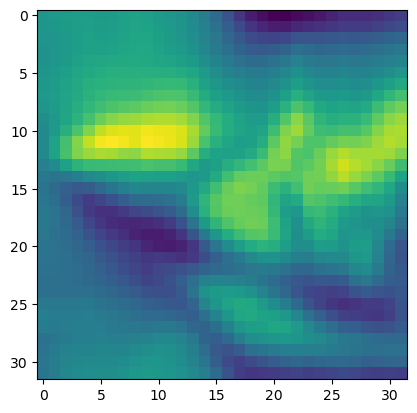

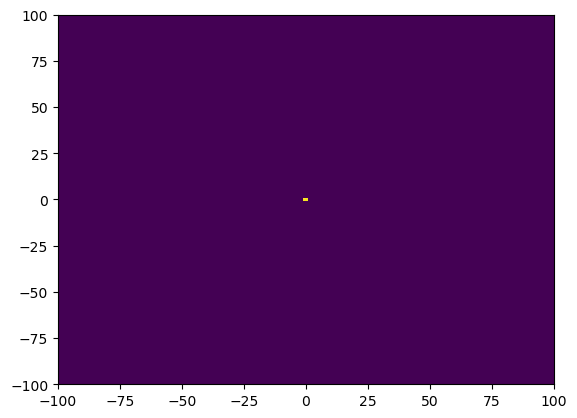

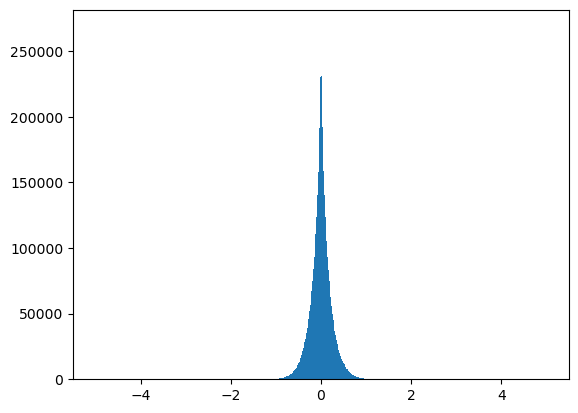

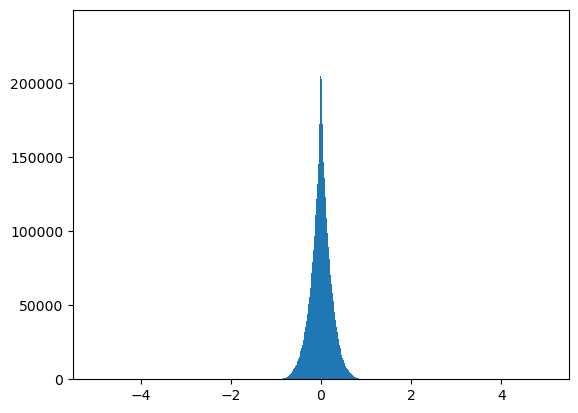

0it [00:01, ?it/s]


In [ ]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


coeff_fn = shifted_spatial_shearlet_transform


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def symlog(x, threshold=1):
    return torch.sign(x) * torch.log(1 + torch.abs(x / threshold))

def symsqrt(x):
    return torch.sign(x) * torch.sqrt(torch.abs(x))

def complex_symsqrt(x):
    real = x.real
    imag = x.imag

    return torch.complex(symsqrt(real), symsqrt(imag))

def complex_symlog(x, threshold=1):
    real = x.real
    imag = x.imag

    return torch.complex(symlog(real, threshold), symlog(imag, threshold))

def shearlet_transform(img):
    return coeff_fn(img.to(0), shearlets.to(0), patch_size)


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)


mean, cov = loader_mean_cov(tqdm(train_loader))

norm = Normalizer(mean, cov)

def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def shearlet_transform(img):

    return norm(coeff_fn(img.to(0), shearlets.to(0), patch_size))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.real.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.real.max())
    print(x.imag.min())
    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    plt.hist2d(x.flatten().real.cpu().numpy(), x.flatten().imag.cpu().numpy(), bins=200, range=[[-100, 100], [-100, 100]])
    plt.show()
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()
    plt.hist(x.flatten().imag.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()
    break